In [4]:
# importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import timedelta
from tqdm import tqdm
import pickle
import category_encoders as ce
import os
from sklearn.preprocessing import StandardScaler
import math
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from hyperopt import hp,fmin,tpe
from prettytable import PrettyTable


# settings
sns.set_style("darkgrid")
import warnings
warnings.filterwarnings("ignore")

# Exploratory Data Analysis

In [2]:
# loading train data, building metadata and weather data 
train_data = pd.read_csv("train.csv",parse_dates=["timestamp"])
building_data = pd.read_csv("building_metadata.csv")
weather_train_data = pd.read_csv("weather_train.csv",parse_dates=["timestamp"])

## Defining Utility Functions

In [2]:
def unique_values_column(data,column):
    '''
    Function to count unique values in a given column
    '''
    
    unique_count = data[column].nunique()
    
    print(f"Number of Unique Values in {column}: {unique_count}")

    

def count_plot(data,column,size=(12,8),rotate=0):
    '''
    Function to plot count of unique values in data
    '''
    
    # plotting the unique counts
    plt.figure(figsize=size)
    plt.title(f"Count of Unique Values: {column}")
    sns.countplot(x=column,data=data,palette="deep")
    plt.xticks(rotation=rotate)
    
    return plt.show()



def plot_readings_building(data,building_id,meter_ids):
    '''
    Function to plot distribution of meter readings by meter type and as well as
    given building id
    '''
    
    # setting the figure
    plt.figure(figsize=(20,20))
    
    # setting color palette
    colors = ["darkcyan","firebrick","purple","darkslateblue"]
    
    # looping through each meter id
    for i,meter in enumerate(meter_ids):
        filt = (data["meter"] == meter) & (data["building_id"]==building_id)
        filtered_data = data[filt]
        
        # plotting the distributions
        plt.subplot(2,2,i+1)
        plt.title(f"Meter Reading Distributions: Meter ID {meter} | Building ID {building_id}")
        sns.histplot(data=filtered_data,x="meter_reading",kde=True,color=colors[i])
    
    return plt.show()




def plot_temperature(data,site):
    '''
    Function to plot avg daily temperature for the available period   
    '''
    
    # filtering based on site
    filt = (data["site_id"] == site)
    filtered_data = data[filt]
    
    # resampling the data to daily level and computing avg temperature
    filtered_data.set_index(keys="timestamp",inplace=True)
    resampled_data = filtered_data.resample("D").mean()
    
    # plotting the avg daily temp
    plt.figure(figsize=(8,6))
    plt.title(f"Avg Daily Temperature at Site ID: {site}")
    plt.plot(resampled_data["air_temperature"])
    plt.xlabel("Timestamp")
    plt.ylabel("Avg Daily Temperature")
    
    return plt.show()   




def reading_time_series(data,building_id,meter_id):
    '''
    Function to plot reading time series given a building id and meter id
    '''
    
    # filtering data by meter id and building id
    filt = (data["building_id"] == building_id) & (data["meter"] == meter_id)
    filtered_df = data[filt]
    
    # plotting the time series
    plt.figure(figsize=(12,8))
    plt.title(f"Meter Readings --> Building ID:{building_id} | Meter ID:{meter_id}")
    sns.lineplot(x="timestamp",y="meter_reading",data=filtered_df)
    
    return plt.show()



def avg_hourly_temp(data,site):
    '''
    Function to plot the average temperature across the year at a given hour 
    '''
    
    # filtering data by site id
    filt = data["site_id"] == site
    filtered_data = data[filt]
    
    # creating column for hour
    filtered_data["hour"] = filtered_data["timestamp"].apply(lambda x: x.hour)
    
    # calculating avg temp by hour
    avg_temp_df = filtered_data.groupby("hour").agg("mean")[["air_temperature"]].reset_index()
    
    # plotting avg temp by hour
    plt.figure(figsize=(8,6))
    plt.title(f"Average Temperature by Hour | Site ID: {site}")
    plt.xlabel("Hour")
    plt.ylabel("Average Temperature")
    plt.bar(x=avg_temp_df["hour"],height=avg_temp_df["air_temperature"],width=1,color="tab:cyan")
    
    return plt.show()


def tag_weekend(x):
    '''
    Function to tag if day is weekend or not
    '''
    
    if x in list(range(5)):
        return "Weekday"
    else:
        return "Weekend"



def consumption_by_daytype(data):
    '''
    Function to plot the median daily energy consumption by day type across buildings 
    filtered by a meter type
    '''
    
    # setting the figure
    plt.figure(figsize=(12,12))
    
    # looping through different meter types
    for meter in range(4):
    
        # filtering data by meter
        filt = data["meter"] == meter
        filtered_data = data[filt]
    
        # adding column for day type
        filtered_data["weekday"] = filtered_data["timestamp"].apply(lambda x: x.dayofweek)
        filtered_data["daytype"] = filtered_data["weekday"].apply(tag_weekend)
    
        # calculating median consumption by day type
        avg_consumption_df = filtered_data.groupby("daytype").agg("median")[["meter_reading"]].reset_index()
    
        # plotting consumption by daytype for given meter
        plt.subplot(2,2,meter+1)
        plt.title(f"Median Consumption by Weekday | Meter ID: {meter}")
        sns.barplot(x="daytype",y="meter_reading",data=avg_consumption_df)
        plt.xlabel("Day Type")
        plt.ylabel("Median Consumption")
    
    
    return plt.show()


def median_hourly_consumption(data,meter):
    
    '''
    Function to plot the median consumption across the dataset at a given hour filtered by meter type  
    '''
    
    # filtering data based on building id
    filt = data["meter"] == meter
    filtered_data = data[filt]
    
    # creating column for hour
    filtered_data["hour"] = filtered_data["timestamp"].apply(lambda x: x.hour)
    
    # calculating median consumption by hour
    avg_consumption_df = filtered_data.groupby("hour").agg("median")[["meter_reading"]].reset_index()
    
    # plotting median consumption by hour
    plt.title(f"Median Consumption by Hour | Meter ID: {meter}")
    plt.xlabel("Hour")
    plt.ylabel("Median Consumption")
    plt.bar(x=avg_consumption_df["hour"],height=avg_consumption_df["meter_reading"],width=1)
    

def weather_var_building_meter(meter_data,weather_data,meter_id):
    '''
    Function to create a joint dataframe with hourly meter readings for a building for a given 
    meter type and corresponding weather variables
    '''
    
    # filtering train data based on meter id
    meter_filt =  meter_data["meter"]==meter_id
    filtered_meter_data = meter_data[ meter_filt]
    filtered_meter_data = filtered_meter_data[["timestamp","meter_reading"]]
    
    # joining the dataframes
    merged_df = weather_data.merge(filtered_meter_data,how="left",on="timestamp")
    
    return merged_df


def weather_consumption_corr(building_id,weather_data,meter_data,building_data):
    '''
    Function to plot building energy consumption heatmap correlation with weather variables 
    '''
    
    # filtering by building id
    filt = meter_data["building_id"] == building_id
    filtered_meter_data = meter_data[filt]
    
    # finding site id for given building
    site = building_data[building_data["building_id"]==building_id]["site_id"].values[0]
    
    # filtering weather data based on site id
    filt = weather_data["site_id"] == site
    filtered_weather = weather_data[filt]
    
    
    # plotting hourly temperature values vs meter readings
    plt.figure(figsize=(24,24))
    
    # looping through different meter types
    for meter in range(4):
        
        # creating required dataframe
        temp_df = weather_var_building_meter(filtered_meter_data,filtered_weather,meter)
        
        # creating correlation subplots for each meter type
        plt.subplot(2,2,meter+1)
        plt.title(f"Building ID: {building_id} | Meter ID: {meter}")
        sns.heatmap(temp_df.corr(),vmin=-1,vmax=1,annot=True,cmap="mako")
    
    return plt.show()


def median_daily_consumption_building(data,meter):
    '''
    Function to compute median daily consumption for buildings for a given meter type
    '''
    
    # filtering based on meter type
    filt = data["meter"] == meter
    filtered_data = data[filt]
    
    # groupby based on building id
    building_group = filtered_data.groupby("building_id")
    building_ids = list(building_group.groups.keys())
    
    # computing median daily consumption for each building
    median_consumption = []
    for building in building_ids:
        temp_df = building_group.get_group(building)
        
        # resampling to daily level and computing median consumption
        temp_df.set_index("timestamp",inplace=True)
        temp_df = temp_df.resample("D").sum()
        median_val = temp_df["meter_reading"].median()
        median_consumption.append(median_val)
    
    # storing results in a new df
    consumption_df = pd.DataFrame(data={"building_id":building_ids,"meter_reading":median_consumption})

    
    return consumption_df


def sqft_correlation(data,building_data):
    '''
    Function returns a correlation plot between energy consumption and building area (sqft)
    '''
    
    # setting figure
    plt.figure(figsize=(16,16))
    
    # looping through meter types
    for meter in range(4):
        
        # computing median daily consumption for buildings based on meter
        consumption_df = median_daily_consumption_building(data,meter)
        
        # taking log of daily consumption values
        consumption_df["log_reading"] = np.log1p(consumption_df["meter_reading"])
        
        # adding square feet to our df based on building id
        merged_df = consumption_df.merge(building_data[["building_id","square_feet"]],how="left",on="building_id")
        
        # correlation plot 
        plt.subplot(2,2,meter+1)
        plt.title(f"Building Area vs Energy Consumption | Meter ID: {meter}")
        sns.scatterplot(x="square_feet",y="log_reading",data=merged_df,color="coral")
    
    return plt.show()



def consumption_by_building_type(data,building_data):
    '''
    Function returns a comparision plot between energy consumption of different building types
    '''
    
    # setting the figure
    plt.figure(figsize=(30,30))
    
    # looping through meter types
    for meter in range(4):
        
        # computing median daily consumption for buildings based on meter
        consumption_df = median_daily_consumption_building(data,meter)
        
        # adding primary use to df based on building id
        merged_df = consumption_df.merge(building_data[["building_id","primary_use"]],how="left",on="building_id")
        
        # group by based on primary use and computing median consumption for each group
        building_type_consumption = merged_df.groupby("primary_use").agg("median")[["meter_reading"]].reset_index()
        
        # comparision plot between different building types
        plt.subplot(2,2,meter+1)
        plt.title(f"Energy Consumption by Building Type | Meter ID: {meter}")
        sns.barplot(x="primary_use",y="meter_reading",data=building_type_consumption,palette="deep")
        plt.xticks(rotation=90)
        plt.ylabel("Median Energy Consumption")
        
    return plt.show()
    

## Data Understanding

Under this section, our objective will be to understand the different data tables that have been provided, get a sense and feel of the different raw features available under each of these data tables and also identify if there are any missing values 

### Train Data

In [7]:
train_data.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


In [8]:
train_data.shape

(20216100, 4)

In [9]:
# analysing missing values in the data
for column in train_data.columns:
    null_count = sum(train_data.isnull()[column])
    print(f"{column}: {null_count} null values")

building_id: 0 null values
meter: 0 null values
timestamp: 0 null values
meter_reading: 0 null values


In [10]:
# start and end dates
print(f"Start Date: {train_data['timestamp'].min()}")
print(f"End Date: {train_data['timestamp'].max()}")

Start Date: 2016-01-01 00:00:00
End Date: 2016-12-31 23:00:00


In [11]:
# unique meters
unique_values_column(train_data,"meter")

Number of Unique Values in meter: 4


In [12]:
# unique buildings
unique_values_column(train_data,"building_id")

Number of Unique Values in building_id: 1449


Observations:

1. There are no missing values that require imputation in the training data 
2. The time frame of the train data is one year of meter readings.
3. These meter readings have been recorded across four different meter types
4. There are 1449 unique buildings in the train data

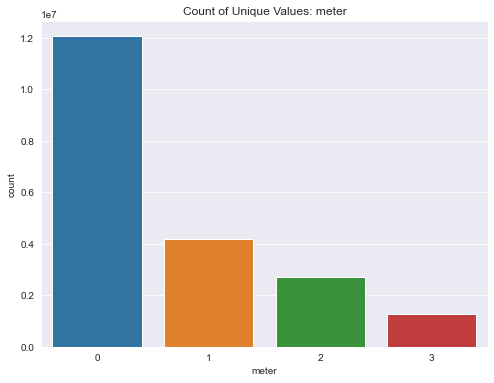

In [13]:
# count plot of meter types
count_plot(train_data,"meter",(8,6))

**Plot Description** 

The above plot depicts the count of records or observations by different meter types. On the x-axis each tick represents the unique or different meter types that we have. And on the y-axis we have the correspinding count of observations or records for each of the different meter types.  

**Plot Analysis**

As observed from the above plot, most of the records or observations pertain to the meter id 0. Out of the 20 million meter readings, around 12 million (approx 60%) of the records are only related to meter id 0. Meter ID 1 has the second highest observations of around 4 million (approx 20%). And the remaining two meters make up the rest of the 20% of observations.

**Plot Conclusion**

Based on the above plot, we can infer that most of the buildings share meter id 0 and this makes logical sense as well because meter 0 relates to electricity. Also we can conclude from the above is that not all buildings have all meter types and we can further explore this relationship by looking at the count of meters by buildings. 

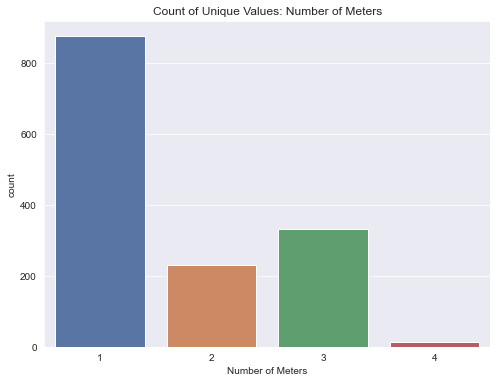

In [40]:
# count of unique meters by building id

# grouping train data by building id
building_group = train_data.groupby("building_id")

# lists for building id and count of unique meters
building_ids = list(building_group.groups.keys())
meter_counts = []

# counting and storing unique meters for each building
for key in building_ids:
    meter_count = building_group.get_group(key)["meter"].nunique()
    meter_counts.append(meter_count)


# creating a df with building id and number of meters
building_num_meters_df = pd.DataFrame({"building_id":building_ids,"Number of Meters":meter_counts})


# plotting countplot of number of unique meters by buildings
count_plot(data=building_num_meters_df,column="Number of Meters",size=(8,6))

**Plot Description** 

The above plot depicts count of buildings based on the number of unique meters they have. On the x-axis, each tick represents the possible total number of meters any building can have (ranging from 1-4). And on the y-axis we have the corresponding count of buildings for each of the possible number of meters.

**Plot Analysis**

It is evident from the above plot that around 900 of the 1449 buildings (approx 60%) only have readings corresponding to a single meter type. On the contrary, very few or rare buildings have meter readings corresponding to all possible meter types.

**Plot Conclusion**

The above plot, further solidifies our findings from the previous plot that not all buildings have all meter types. And the buildings that only have a single meter type, would most commonly but not necessarily have meter id 0.

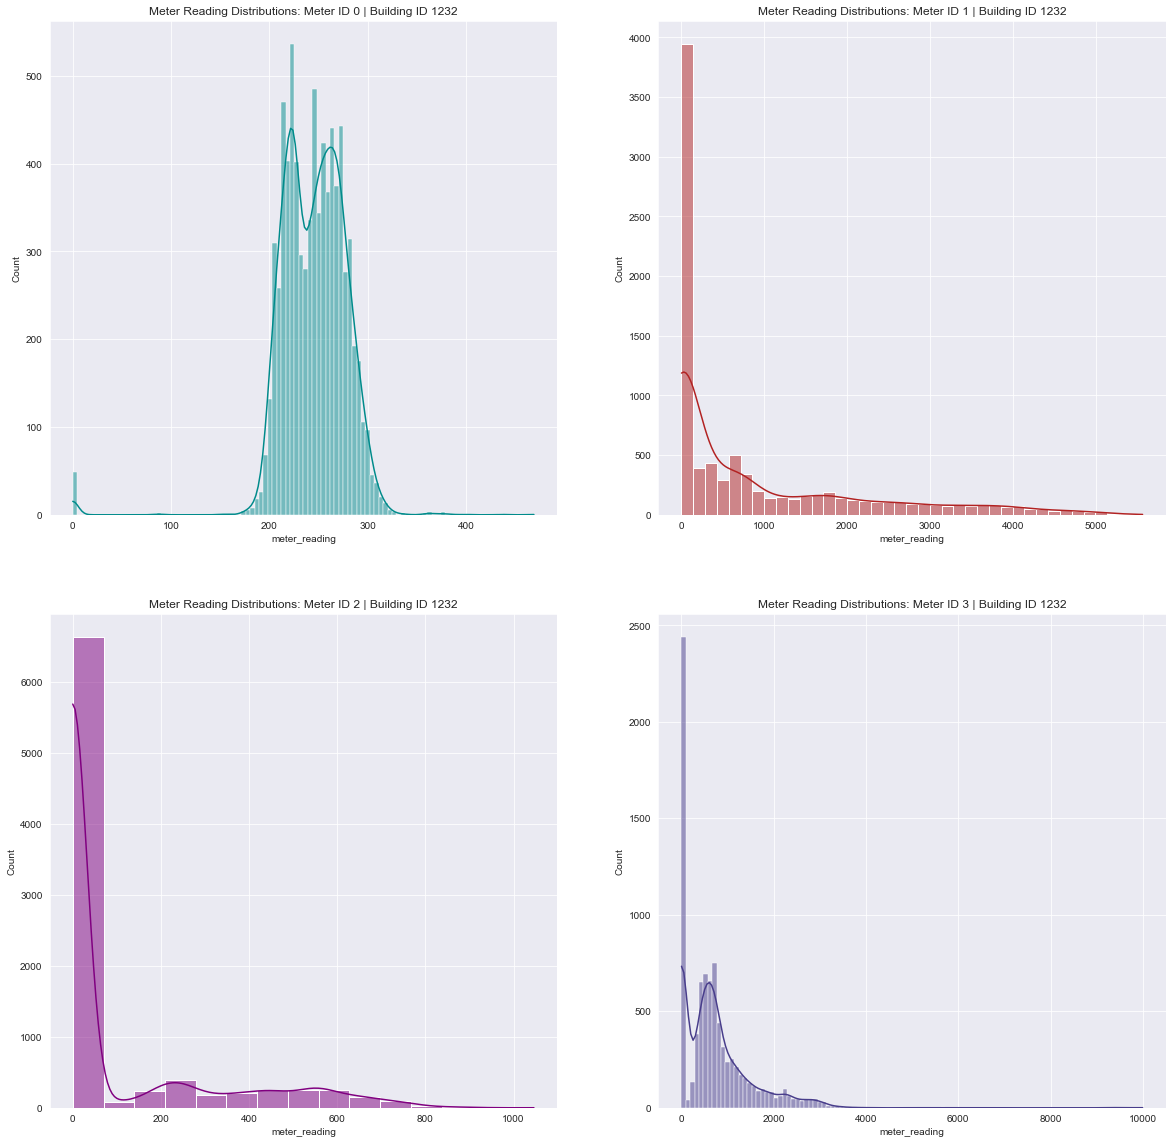

In [141]:
# sample meter reading distributions by meter type for two buildings

# list of building ids with all four meters
buildings_all_meters = list(building_num_meters_df[building_num_meters_df["Number of Meters"]==4]["building_id"])

# randomly selecting two building ids
random_buildings = random.sample(buildings_all_meters,k=2)

# list of unique meter ids
meter_ids = sorted(list(train_data["meter"].unique()))

# plotting distributions for the first randomly selected building
plot_readings_building(train_data,random_buildings[0],meter_ids)

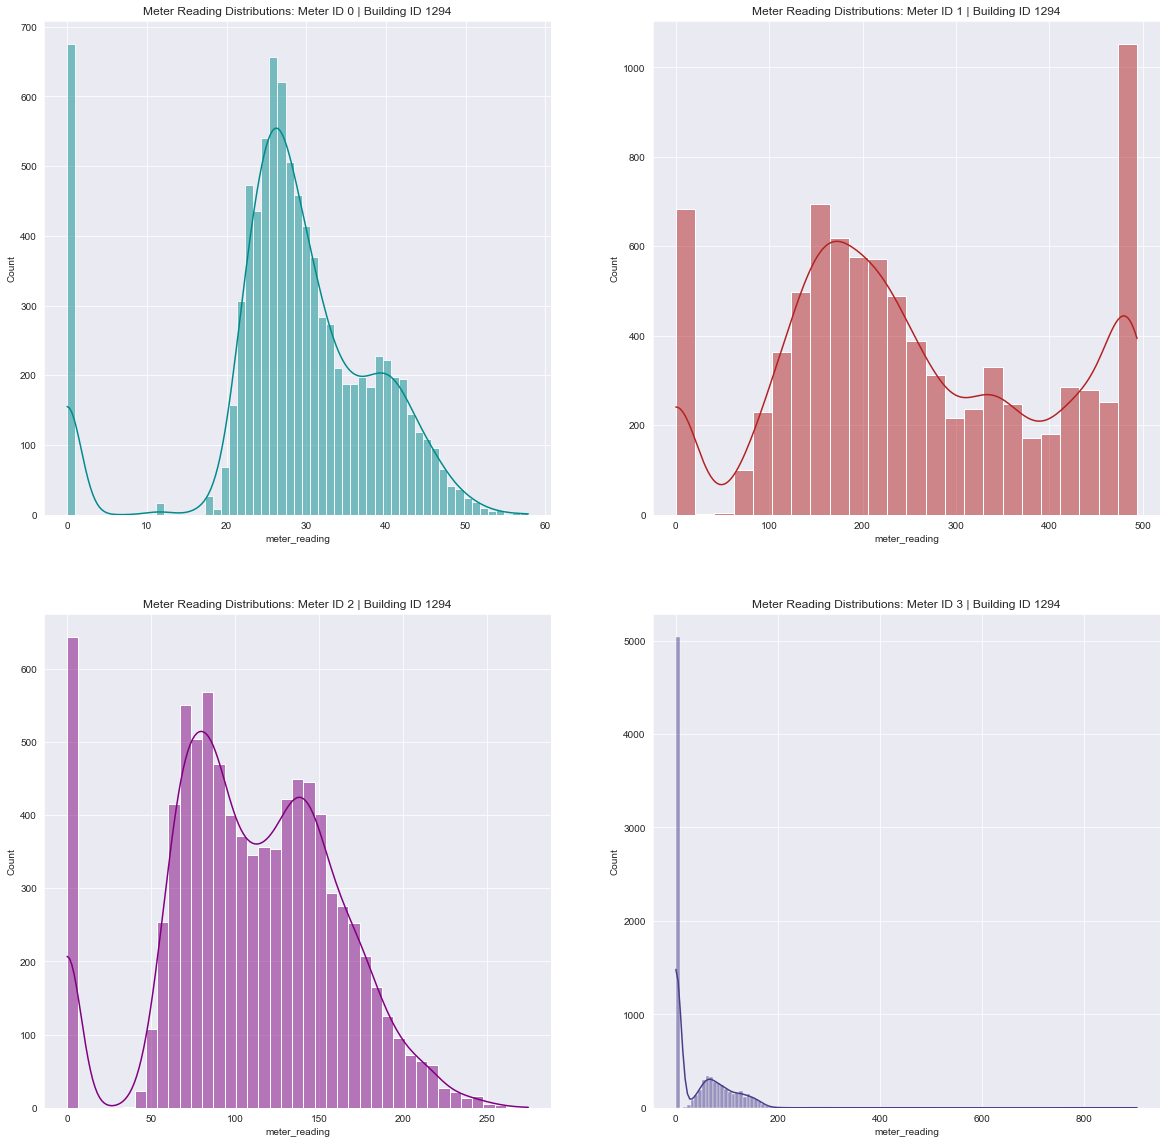

In [142]:
# plotting distributions for the second randomly selected building
plot_readings_building(train_data,random_buildings[1],meter_ids)

**Plot Description** 

The above plots depict distributions of meter readings by all the meter types and for a given building id. In essence each plot relates to a single building and then each subplot depicts the energy consumption distribution by meter type. We have randomly chosen 2 buildings (which are installed with all meter types) to analyze the distributions. For each subplot the x-axis represents the meter readings and the y-axis represents the corresponding counts (histogram) and probability density (pdf).  

**Plot Analysis**

A careful analysis, reveals that in almost all plots there are a number of meter readings with zero values. Another observation is that in case of all meter types, we do have some range of normal readings but there are a few instances where extreme values can be seen or to put it concisely we have right skewed distributions.

**Plot Conclusion**

Based on the above plots, it is important to highlight that data cleaning and preprocessing will be crucial. The meter readings are our target variables and as seen there are some abnormalities which we need to remove. We will further explore these in the coming sections of data preprocssing.

### Weather Data

In [56]:
weather_train_data.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [57]:
weather_train_data.shape

(139773, 9)

In [58]:
# start and end dates
print(f"Start Date: {weather_train_data['timestamp'].min()}")
print(f"End Date: {weather_train_data['timestamp'].max()}")

Start Date: 2016-01-01 00:00:00
End Date: 2016-12-31 23:00:00


In [59]:
# unique sites
unique_values_column(weather_train_data,"site_id")

Number of Unique Values in site_id: 16


In [60]:
# analysing missing values in the data
for column in weather_train_data.columns:
    null_count = sum(weather_train_data.isnull()[column])
    print(f"{column}: {null_count} null values")

site_id: 0 null values
timestamp: 0 null values
air_temperature: 55 null values
cloud_coverage: 69173 null values
dew_temperature: 113 null values
precip_depth_1_hr: 50289 null values
sea_level_pressure: 10618 null values
wind_direction: 6268 null values
wind_speed: 304 null values


**Observations:**

1. Similar to the meter readings data, the weather data has also been provided for one year with hourly intervals.
2. There are 16 different sites for which weather data has been provided.
3. A number of features have missing or null values, with cloud coverage being the feature with most missing records.

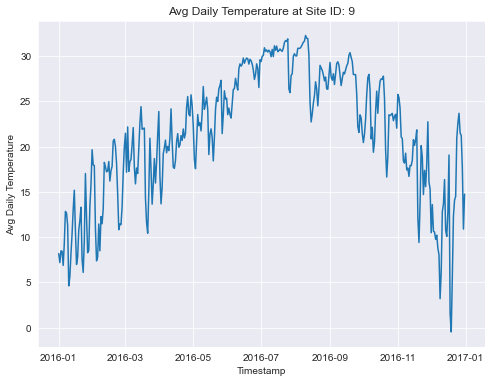

In [97]:
# plotting avg daily temperature for two random sites

# randomly picking two sites
random_sites = random.sample(list(range(16)),k=2)

# plotting avg daily temperature for first random picked site
plot_temperature(weather_train_data,random_sites[0])

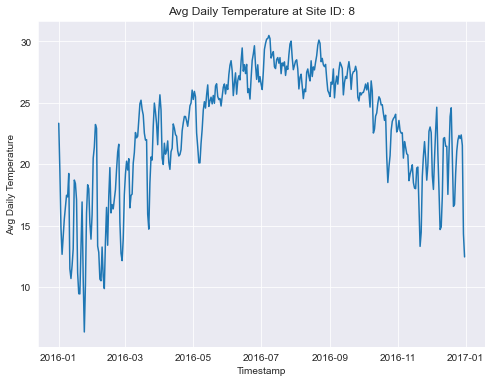

In [98]:
# plotting avg daily temperature for second random picked site
plot_temperature(weather_train_data,random_sites[1])

**Plot Description** 

The above plots depict the trends of daily average temperature for two randomly chosen sites. On the x-axis we have the timestamp and on the y-axis we have the corresponding the daily average temperature. 

**Plot Analysis**

From the above plots, it is quite visible to observe the trends in the daily average temperature based on the seasons. Both the plots show lower temperatures around the months of Jan-Mar. From the month of May, we can observe that the temperatures continue to increase up until around July and they start falling again from September.

**Plot Conclusion**

From the observations we can conclude that all of our sites and consequently all of our buildings are located in the Northern Hemisphere. This fact can be supported because of the seasonal patterns observed which match the Northern Hemisphere.

### Building Data

In [99]:
building_data.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [100]:
# unique buildings
unique_values_column(building_data,"building_id")

Number of Unique Values in building_id: 1449


In [102]:
# unique primary uses
unique_values_column(building_data,"primary_use")

Number of Unique Values in primary_use: 16


In [106]:
# analysing missing values in the data
for column in building_data.columns:
    null_count = sum(building_data.isnull()[column])
    print(f"{column}: {null_count} null values")

site_id: 0 null values
building_id: 0 null values
primary_use: 0 null values
square_feet: 0 null values
year_built: 774 null values
floor_count: 1094 null values


**Observations:**

1. As observed from the training data as well, we have 1449 unique buildings
2. We have 16 distinct primary uses in which buildings can be categorized
3. The features year built and floor count have lots of null or missing values.



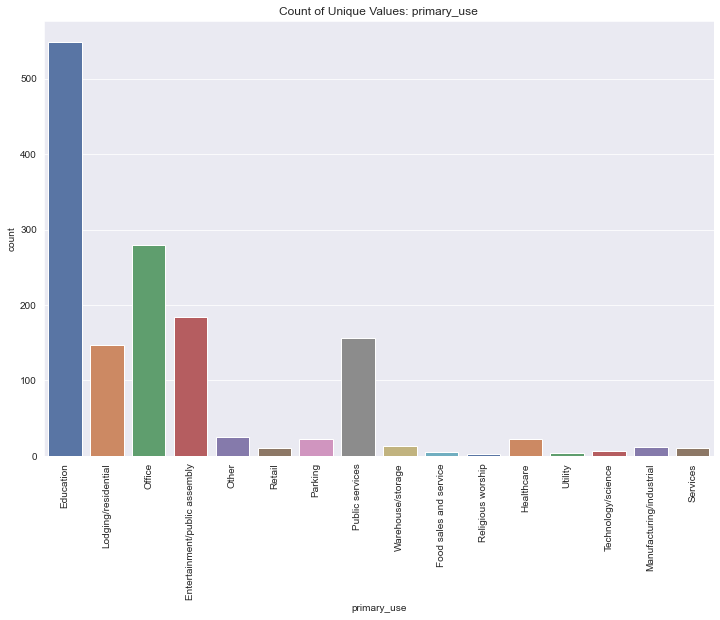

In [183]:
# count of buildings by their primary use
count_plot(building_data,"primary_use",rotate=90)

**Plot Description** 

The above plot shows the building counts by their primary use. On the x axis each tick represents one of the unique primary use categories and the y-axis represents their corresponding counts.   

**Plot Analysis**

As observed from the above plot, roughly around 35-40% of the buildings are primarily used for educational purposes. After education, the second most observed primary use is "Office" which represent approximately 20% of all buildings.

**Plot Conclusion**

As most of the buildings are either educational instituions or office spaces, it would be important to consider factors such as time of day, day type, public holidays etc. while selecting features to predict the target variable.

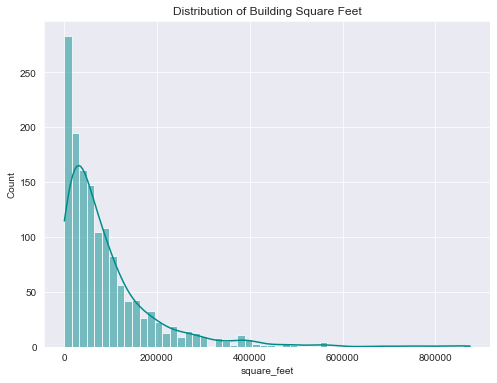

In [131]:
# plotting the distribution of building square feet
plt.figure(figsize=(8,6))
plt.title("Distribution of Building Square Feet")
sns.histplot(data=building_data,x="square_feet",kde=True,color="darkcyan")
plt.show()

**Plot Description** 

The above plot depicts the distribution of the building area in square feet. On the x-axis we plot the building area in terms of square feet and y-axis represents the corresponding counts (histogram) and probability density(pdf).    

**Plot Analysis**

The distribution of building square feet appears to be right skewed, with most of the buildings having an area of less than 200k square feet. A very small proportion of buildings are spread across a large area.

**Plot Conclusion**

Although most of the buildings have similar area coverage, but we still do observe some variation in the building square feet distribution. And because energy requirements would largely be affected by a buildings size we need to consider this while defining our features.   

In [168]:
# adding a decade column for the year built

decades = ["1890-1900","1900-1910","1910-1920","1920-1930","1930-1940","1940-1950","1950-1960","1960-1970",
           "1970-1980","1980-1990","1990-2000","2000-2010","2010-2020"]

decade_bins = list(range(1890,2030,10))

building_data["decade_built"] = pd.cut(building_data["year_built"],bins=decade_bins,labels=decades)

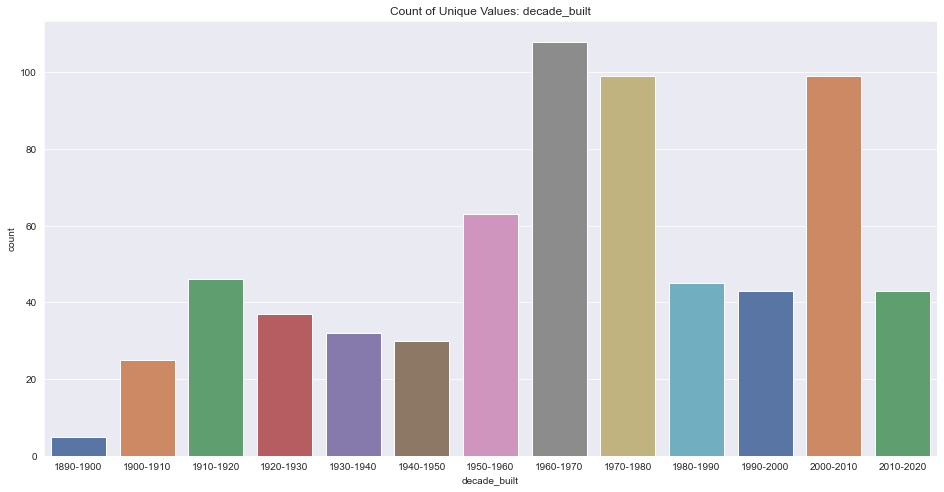

In [184]:
# count plot of buildings by decade built
count_plot(building_data,"decade_built",size=(16,8),rotate=0)

**Plot Description** 

The above plot represents the counts of buildings by the decade in which they were built. On the x-axis each tick represents a decade and the corresponding y-axis shows the count of buildings that were constructed in that decade.    

**Plot Analysis**

One key observation from this plot, apart from the counts is that we have buildings with varying ages in the dataset. In terms of counts, we can observe that a large proportion of the buildings in the dataset where constructed around 1960-1980's and also between 2000-2010.

**Plot Conclusion**

Based on our literature review, we had observed that age of a building can significantly affect the energy efficiency levels and hence since in our dataset we have buildings from different eras we can utitlize to predict our target variable.   

## Identifying Anamolies

Under this section we will try to focus our efforts on finding if there are any anamolies in our data which we might need to correct out in our data preprocessing.

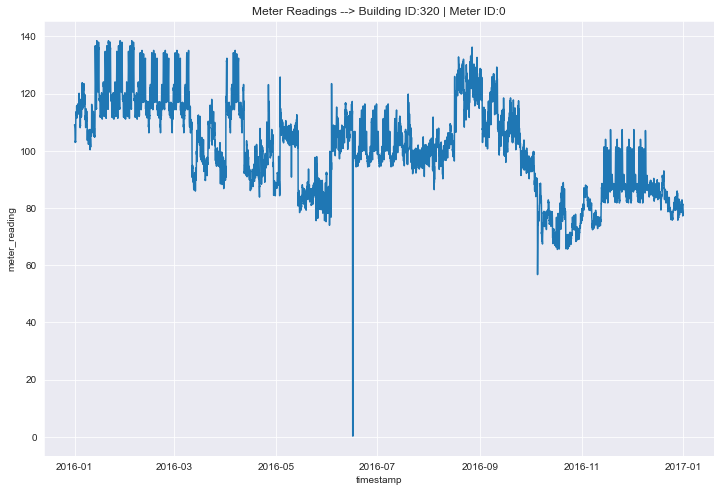

In [9]:
# plotting a few example meter reading time series where spikes or anboormalities were observed

reading_time_series(data=train_data,building_id=320,meter_id=0)

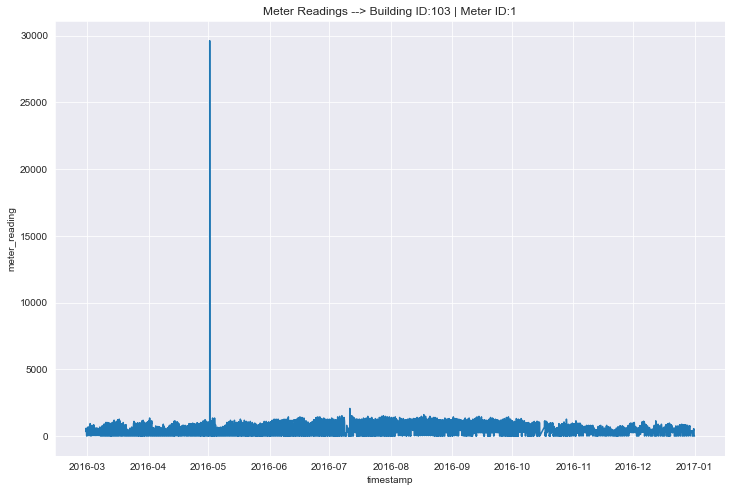

In [11]:
reading_time_series(data=train_data,building_id=103,meter_id=1)

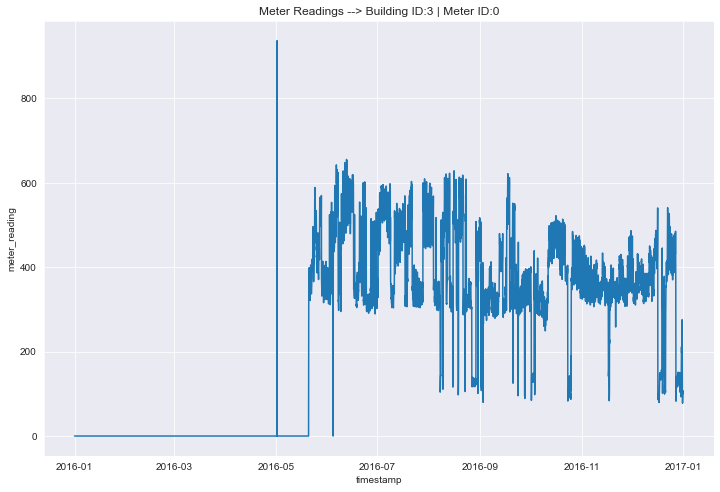

In [10]:
reading_time_series(data=train_data,building_id=3,meter_id=0)

**Plot Description** 

The above plots are time series plots filtered by a building id and for a specific meter type. On the x-axis we have the time horizon or the time element. And on the y-axis we have the corresponding meter readings.  

**Plot Analysis**

As seen above, I have tried to plot samples of each of the different abnormalities that are observed throught the dataset. In the first plot we can observed that there is a sudden negative spike. The second plot is an exact opposite of the first plot where we see constant values and then a sudden positive spike. The third plot type represents a scenario which is prevelant in the data where for a long period of time we have constant reading of zero.   

**Plot Conclusion**

Based on these observations, we can conclude that we have certain abnormalities in the meter readings maybe because of equipment malfunction or the sensors might have stopped recording. And because the meter readings are the target variables that we need to predict as part of this problem, it would be crucial to detect such anamolies across the dataset and remove these.

    

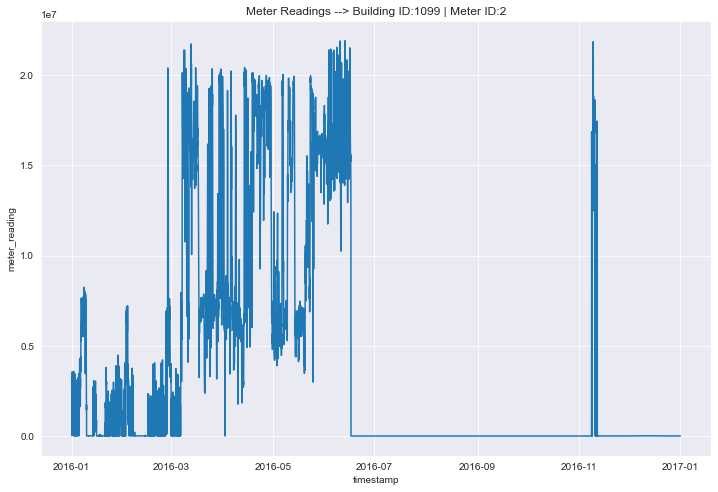

In [11]:
# plotting time series for building 1099 meter 2
reading_time_series(data=train_data,building_id=1099,meter_id=2)

**Plot Description** 

The above plot depicts the meter readings for building id 1099 and meter 2. Similar to the earlier time series plots, on the x-axis we have the timestamps and on the y-axis we have the corresponding meter readings.  

**Plot Analysis**

For building id 1099 and meter id 2, we can see very high meter readings in the range of around 1e7. Along with these extreme readings we can also observe that the reading almost flattens out to zero between July to November.   

**Plot Conclusion**

Based on visual inspection, we can conclude that building id 1099 is showing a lot of absurd readings. We need to clean these target variables out so that it does not adversely affect our model training.

    

**Time Zone Offset**

reference: https://www.kaggle.com/patrick0302/locate-cities-according-weather-temperature

Several competition participants identified that for a few sites in the weather data, the time zones were in terms of UTC and not local time. In order to further analyze this from our end we will be plotting for a few site ids the average temperature for each hour across the whole year.

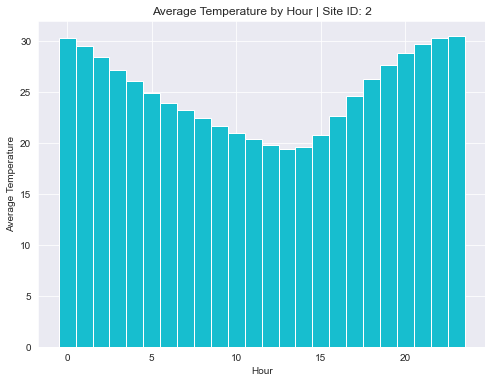

In [54]:
# plotting average temperature by hour for a few sites which have been identified with time zone off set
avg_hourly_temp(weather_train_data,2)

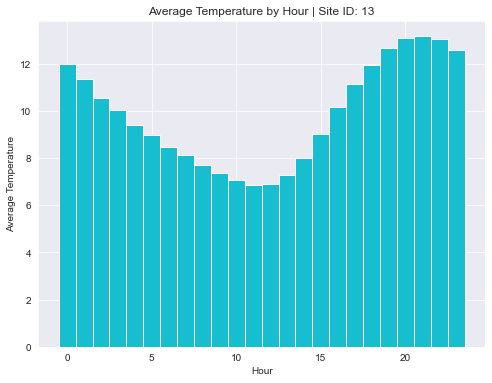

In [55]:
avg_hourly_temp(weather_train_data,13)

**Plot Description** 

The above plots filtered by site id reflect the average temperature at a given hour across the observed timeperiod. On the x-axis we have the time of the day and on the y-axis we have the corresponding average temperature.  

**Plot Analysis**

In both the plots, we can observe that the temperature value peaks at around 2100 hours or 9pm. Similarly, we can also observe that the temperature drops at around 1200 hours or at noon.  

**Plot Conclusion**

Based on these observations, we can definetly conclude that the timestamps in the weather data are based on UTC and not local. Because the temperature peak and drop seem to be counter-intuitive, we generally expect to see temperature peak during noon time and lower temperatures during night.

## Relationship between Features and Target Variable

Under this section our objective will be to decode the relationship between our various features and target variable (meter reading). All analysis and exploration will be focused on finding features which are correlated or affect energy consumption.

### Datetime Features

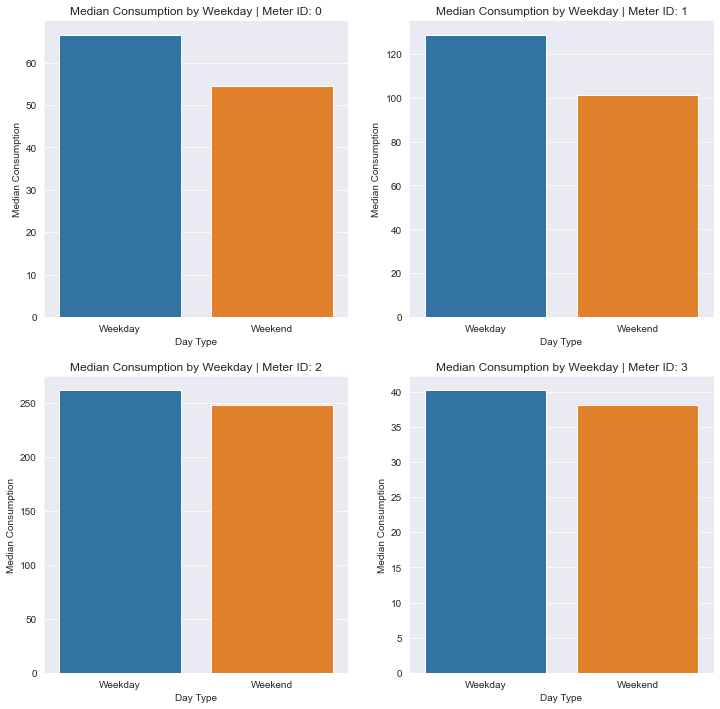

In [271]:
# plotting the average consumption based on daytype (weekday or weekend) for each meter type
consumption_by_daytype(train_data)

**Plot Description** 

The above plots depict difference between energy consumption on weekdays and weekends. Each subplot represents data filtered out based on the meter id. On the x-axis we represent the type of day and on the y-axis we plot the corresponding median meter readings or consumptions across the dataset for the specific meter type. The reason for using median and not the mean is because the presence of outliers in meter readings observed earlier might skew our findings.    

**Plot Analysis**

For meter types 0,1,2 we can clearly observe that the median consumption on weekdays is higher than that on weekends. For meter type 3 the median consumption looks almost similar on weekend and weekdays but a closer look would reveal that the consumption is slightly higher on  weekdays.  

**Plot Conclusion**

Based on these observations, we can infer and conclude that the energy consumption pattern vary based on the type of day and it is especially lower on weekends (as one would expect). Hence we need to consider these factors while creating the model inputs.  

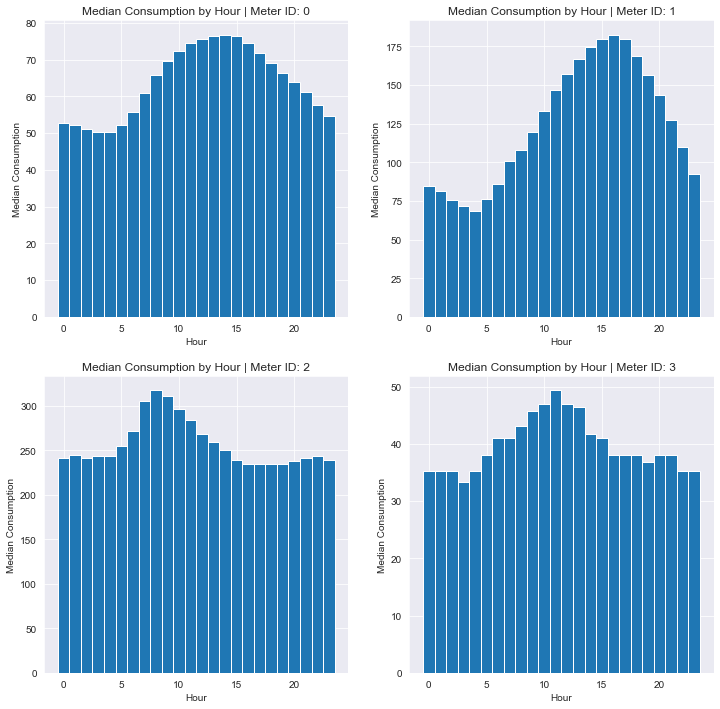

In [5]:
# plotting average consumption given hour of the day based on the meter id
plt.figure(figsize=(12,12))

for i in range(4):
    plt.subplot(2,2,i+1)
    median_hourly_consumption(train_data,i)

**Plot Description** 

These plots try to depict the energy consumption patterns based on the hour of the day. Each subplot is filtered by the specific meter type. On the x-axis we plot the hours of the day and on the y-axis the corresponding median energy consumption at that given hour across the dataset. 

**Plot Analysis**

One common observation among all meter types is that energy consumption is comparitively lower during night and higher during daytime. Meter ID 0 and 1 show an increase in energy consumption starting from around 10am and reach peak by afternoon. On the other hand Meter ID 2 and 3 reach their peak between 6am - 8am and then start falling by 9am. When we look at the data description provided, meter id 0,1,2 and 3 represent electricity, chilled water, hot water and steam related energy consumption. In this sense the observations also seem intuitive because for example we expect chilled water related energy consumption to peak during afternoon hours and then fall off during night and this is exactly the behaviour observed from the plot of meter id 2.

**Plot Conclusion**

Based on these observations we can conclude that for each of the different meter types, the hour of the day plays an important factor for determining energy consumption levels. We can utilize the hour of day as an indicator to predict our target variable.





### Weather Features

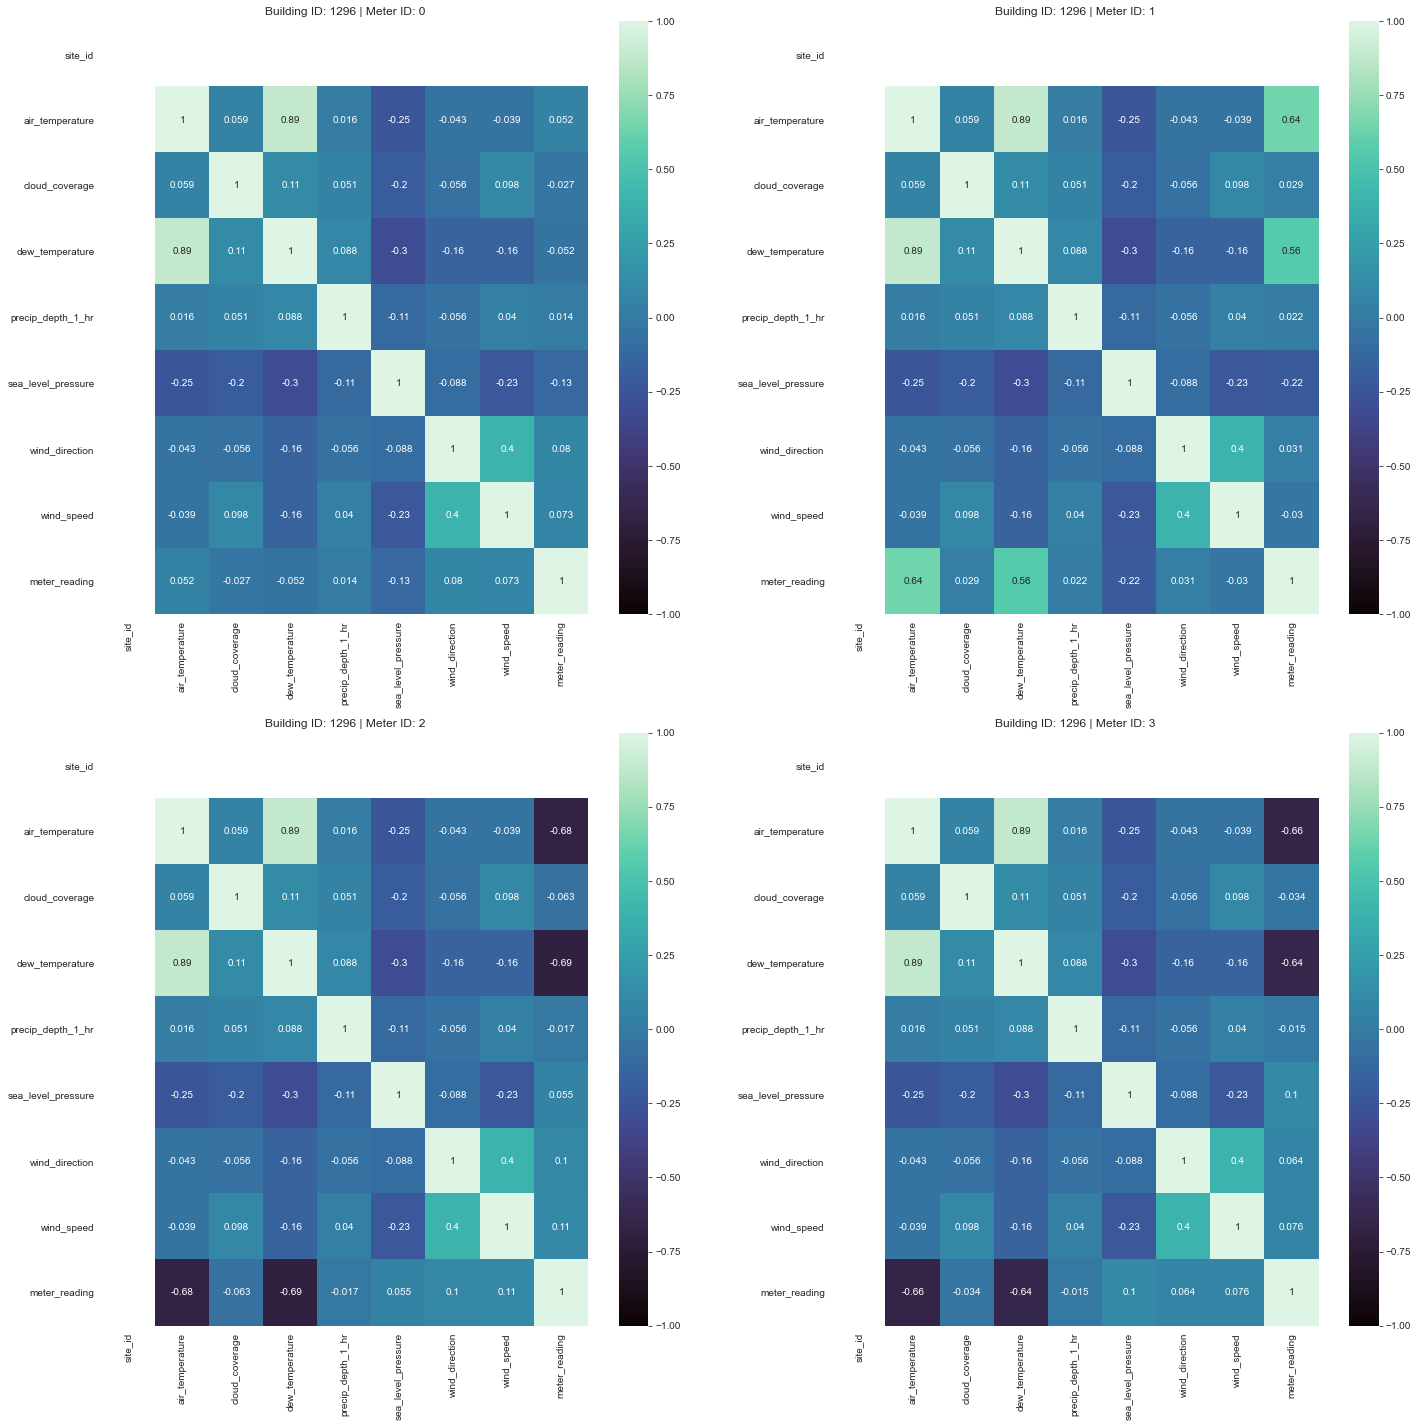

In [89]:
# plotting correlation heatmap between weather variables and energy consumption for a specific building

# list of building ids with all four meters
buildings_all_meters = list(building_num_meters_df[building_num_meters_df["Number of Meters"]==4]["building_id"])

# randomly selecting two building ids
random_buildings = random.sample(buildings_all_meters,k=2)

# plotting correlation heatmap for first randomly selected building
sns.set_style("white")
weather_consumption_corr(random_buildings[0],weather_train_data,train_data,building_data)

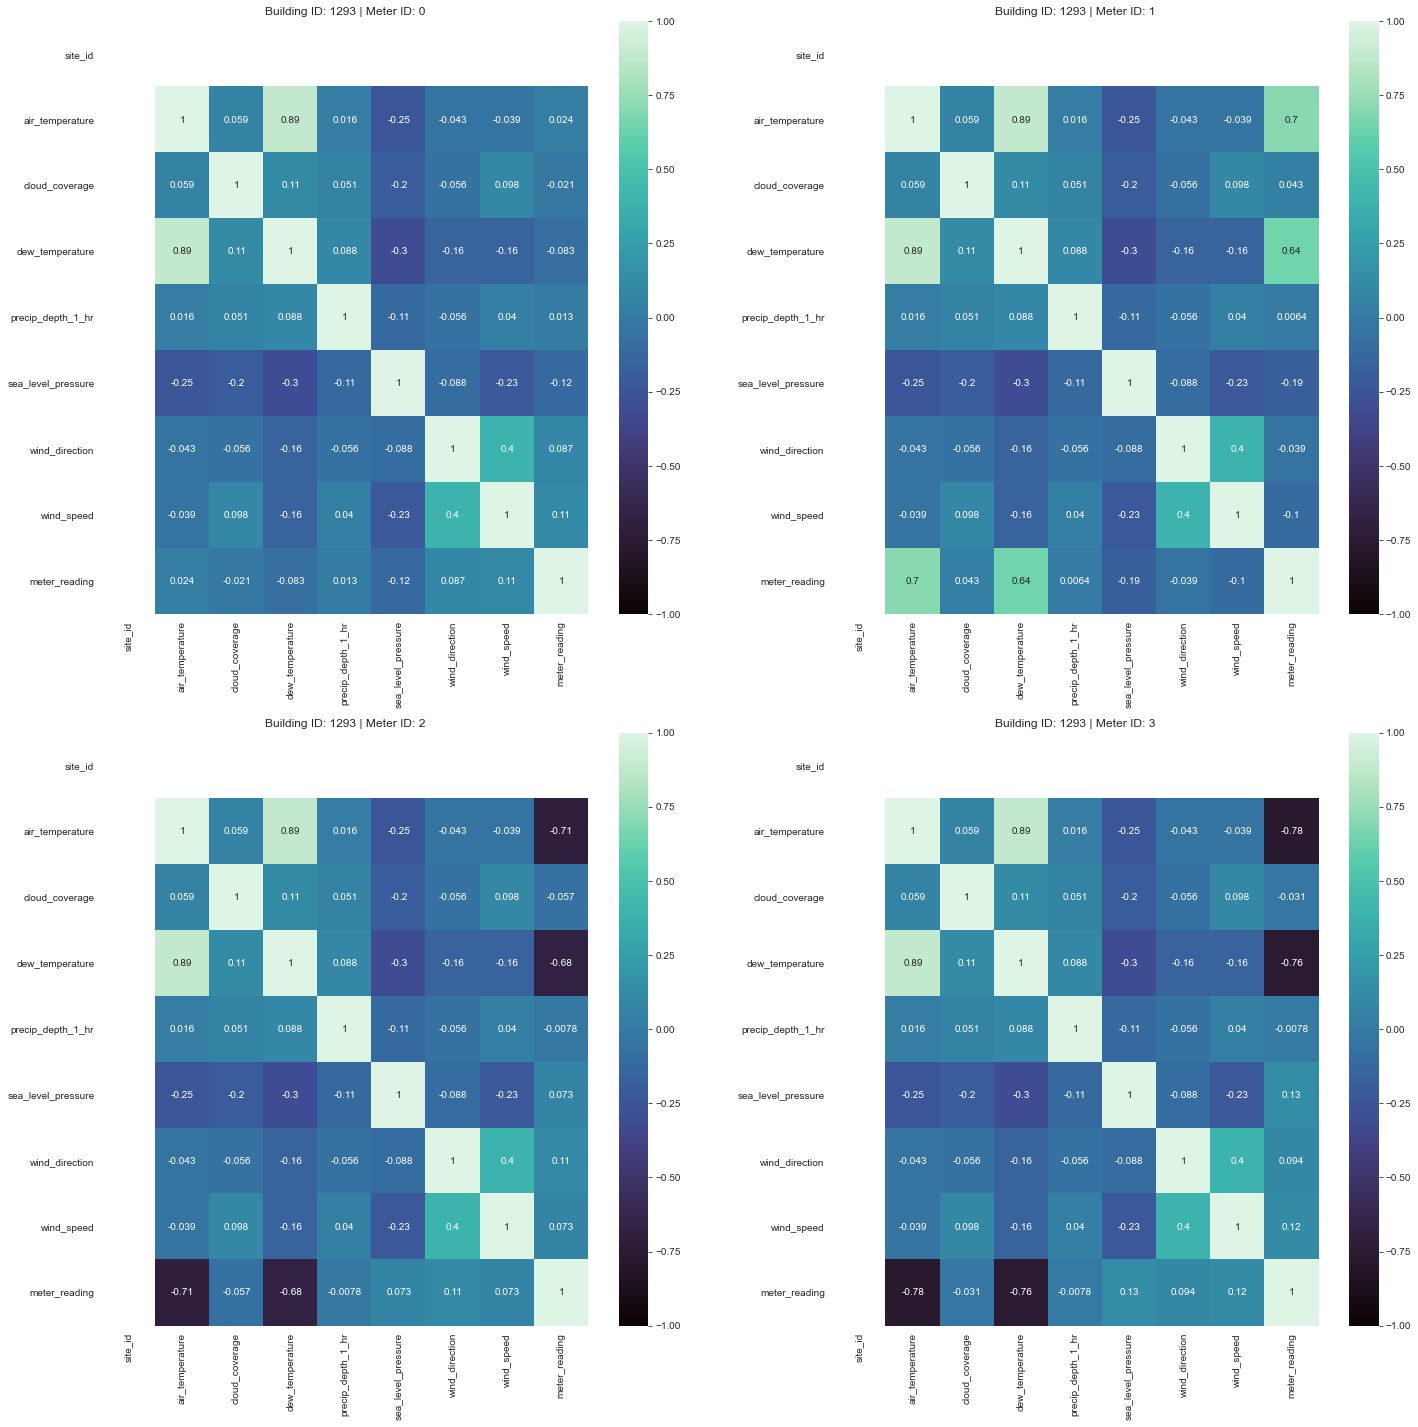

In [90]:
# plotting correlation heatmap for second randomly selected building
weather_consumption_corr(random_buildings[1],weather_train_data,train_data,building_data)

**Plot Description** 

These heat-maps try to depict the correlation between weather variables and our target variable "meter_reading". We have randomly selected two buildings which have all four meter types and then tried to measure the correlation coefficient between meter readings and weather variables. Each subplot is filtered by a given building and meter id. And each cell in the heatmap matrix represents the correlation coefficient between two variables. 

**Plot Analysis**

For both the buildings, air temperature and dew temperature have very strong correlation with Meter ID 1,2 and 3. Air Temperature and Dew Temperature are both positively correlated with energy consumption readings from meter id 1. Since this meter relates to chilled water it also makes intuitive sense because as temperature increases we expect increased cooling requirements. On the contrary air temperature and dew temperature have strong negative correlation with readings from meter id 2 and 3. This indicates that as temperature drops, there is increase in energy consumption, which again makes intuitive sense as meter 2 and 3 are related to heating requirements. Wind Direction, Wind Speed and Sea Level Pressure show weak correlation with meter readings, and the other variables have correlation values around zero.    

**Plot Conclusion**

Based on these observations we can conclude that air temperature and dew temperature are important indicators for predicting energy consumption. Along with these wind direction, wind speed and sea level pressure might also be helpful in trying to model our target variable. Other two variables Cloud Coverage & Percipitation do not correlate well and might not be helpful in predicting the target variable. 




### Building Metadata

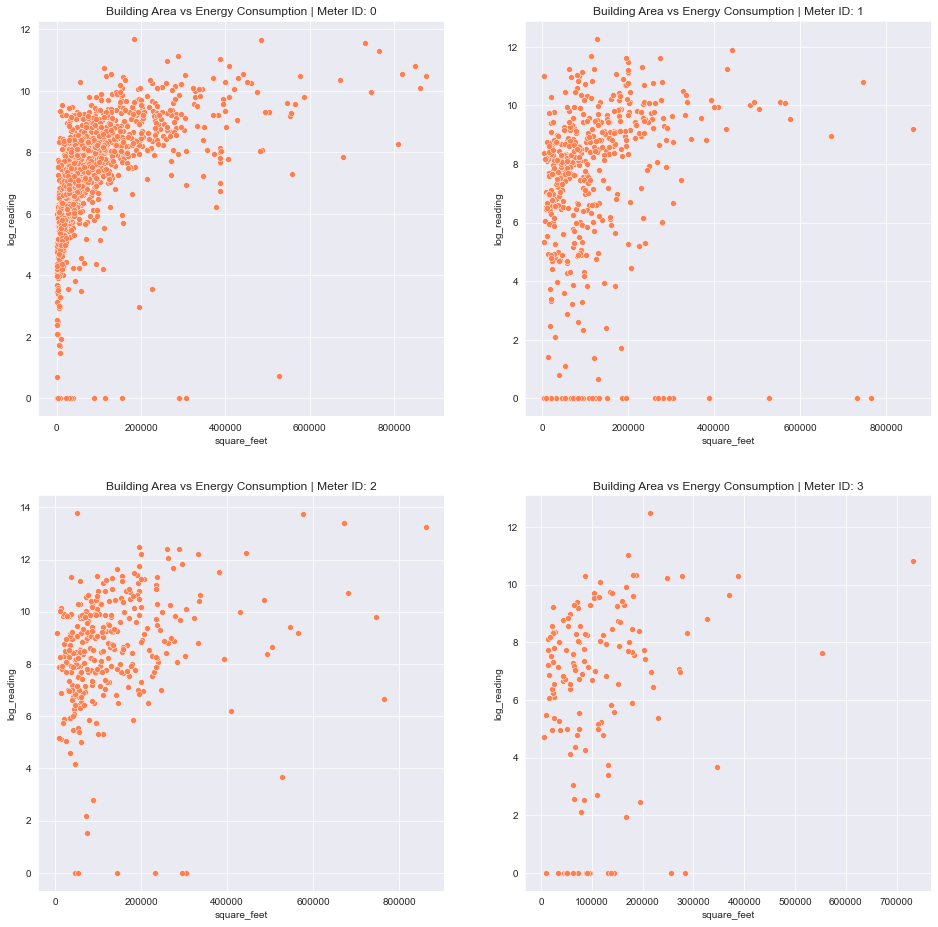

In [15]:
# plotting correlations between building area or size with energy consumption based on meter type
sqft_correlation(train_data,building_data)

**Plot Description** 

These plots try to depict correlation between building square feet and energy consumption for a given meter type. For each subplot, the x-axis represents the building area or square feet and the y-axis represents the log of median daily consumption by the building.

**Plot Analysis**

For each of the plots, we can observe that in most cases as the building area or square feet increases, we see an increase in the median consumption by the building. There is not an extremely strong correlation between buidling area and energy consumption, but we can generally say that as building area increases, we can expect an increase in energy consumption.  

**Plot Conclusion**

Based on these observations we can conclude that there exists a positive correlation (although not very strong) between building area and energy consumption. And this pattern is observed amongst all different meter types. Hence we can consider building area as an input for predicting energy consumption.


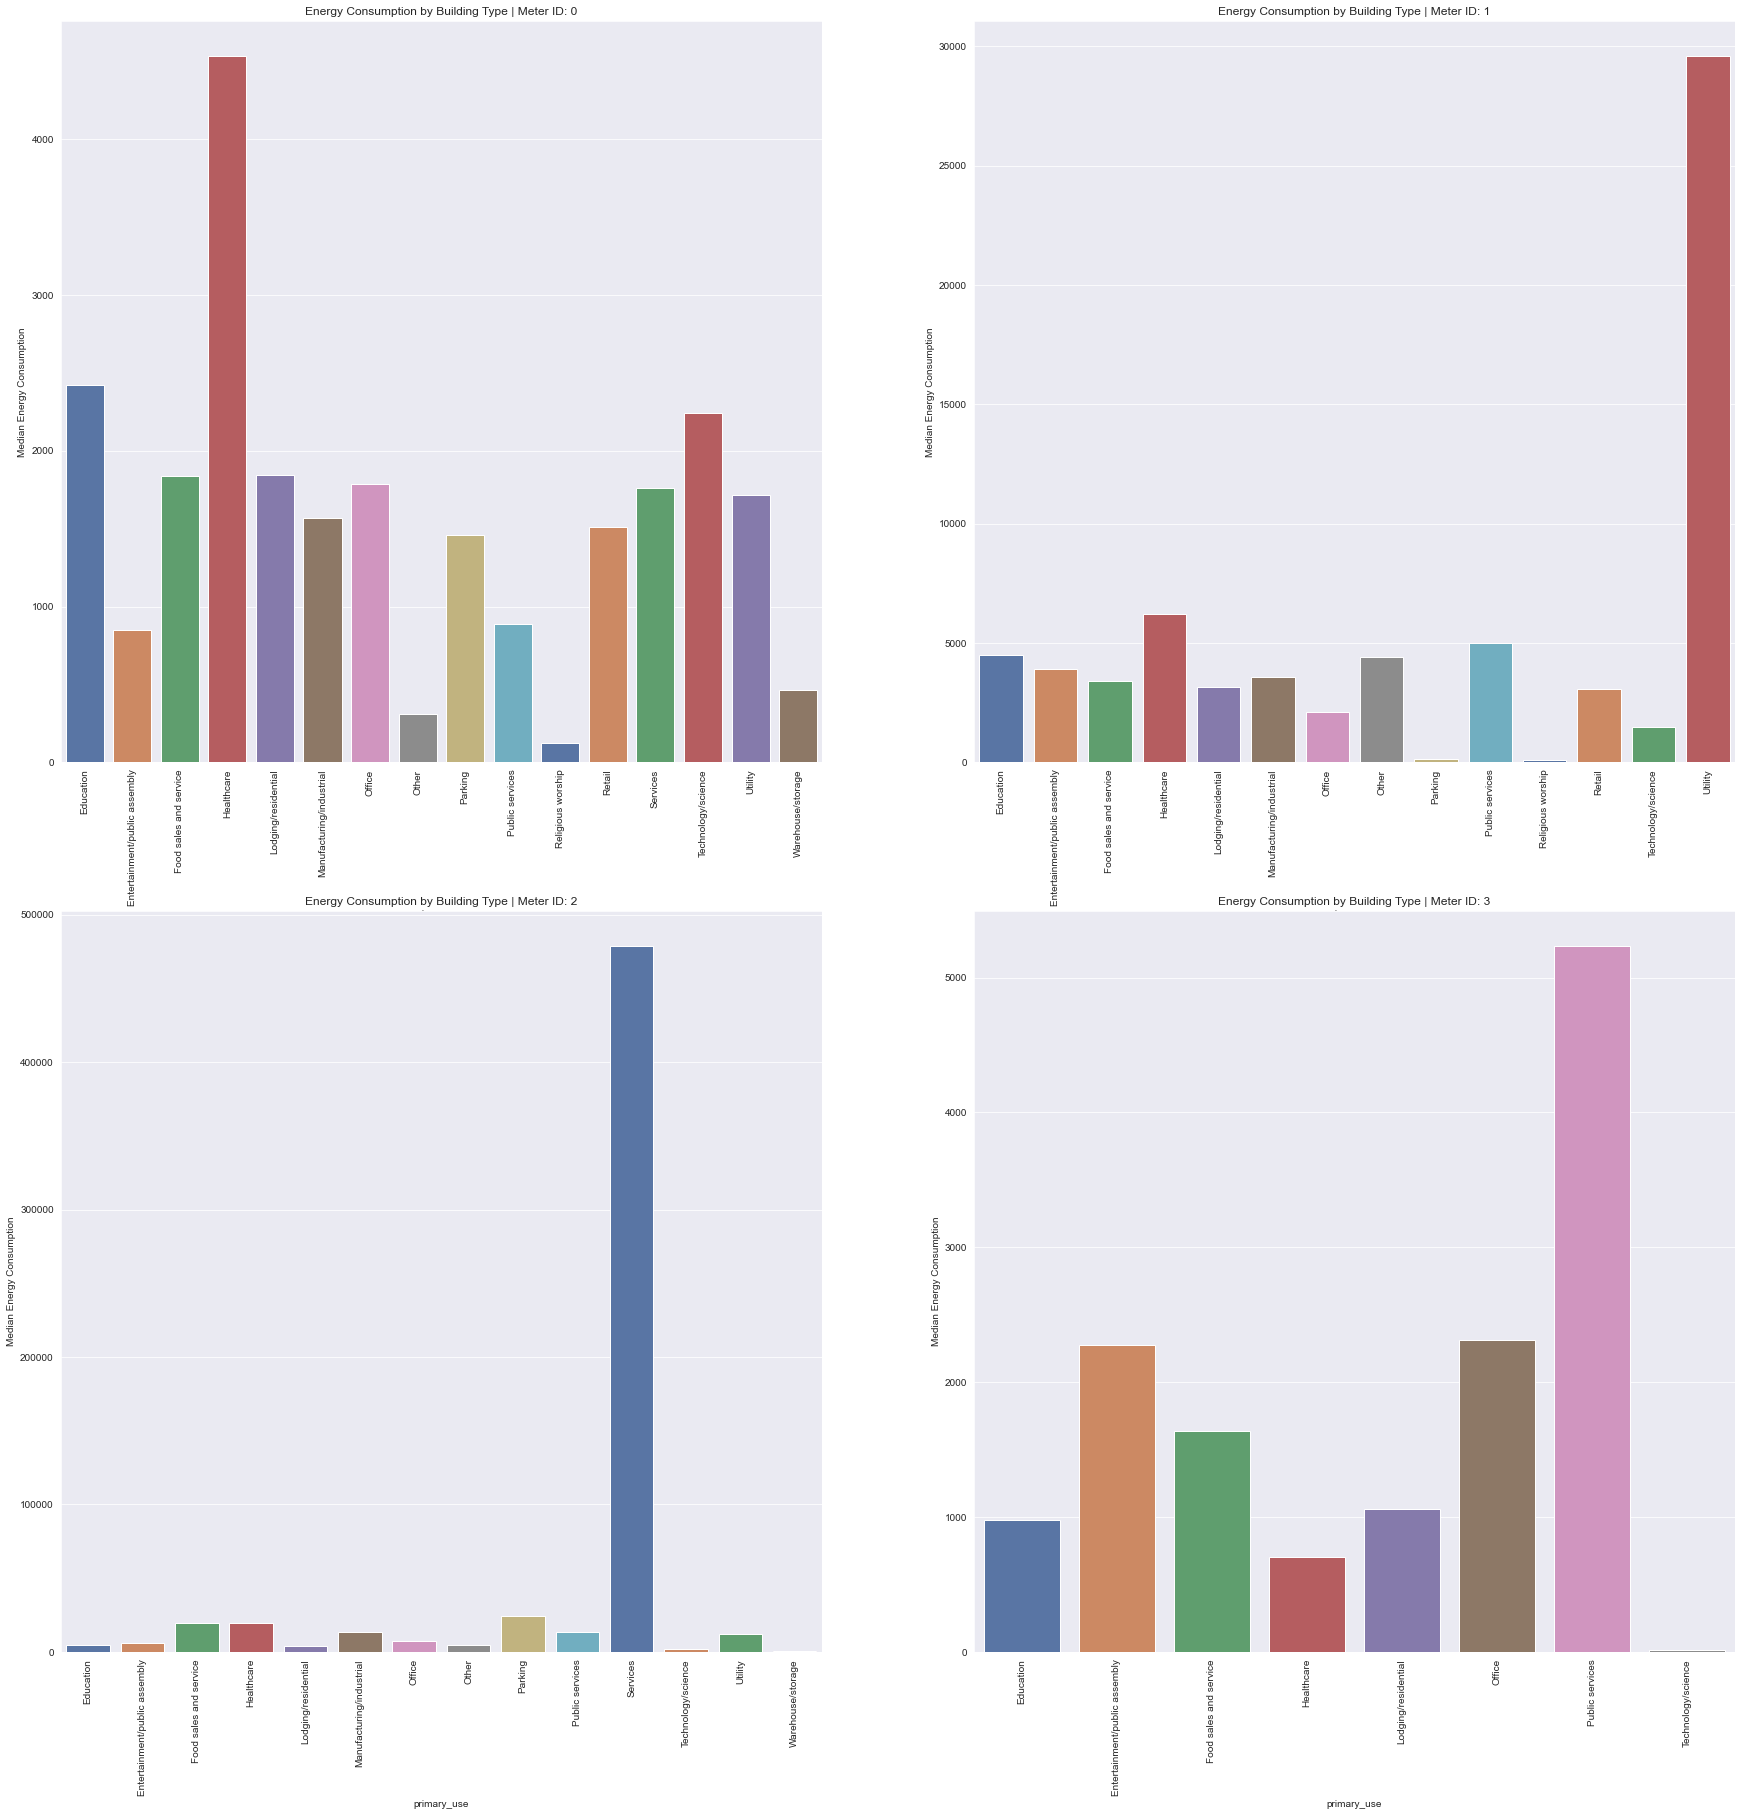

In [42]:
consumption_by_building_type(train_data,building_data)

**Plot Description** 

These plots try to draw out a comparision of energy consumption by primary use or purpose of a building. For each of the subplots, on the x-axis we represent the different building types and on the corresponding y-axis we represent the median daily energy consumption of those building types.

**Plot Analysis**

A quick observation for plots of each meter type reveals that energy consumption varies greatly based upon the building type. For meter id 0 we observe that buildings with primary use of health care have the highest median daily energy consumption. Similarly meter id 1,2 and 3 have highest consumption for building types utility, services and public services respectively.  

**Plot Conclusion**

Based on these observations we can conclude that energy consumption patterns largely depend on the primary use or purpose of a building. Hence the building type will be very a important feature for predicting the target variable.


# Data Processing and Cleaning

Under this section we will be preprocessing and cleaning the data so that it is ready to be modelled upon. Data processing will be based upon the findings uncovered during the EDA phase.

## Defining Utility Functions

In [ ]:
# creating dictionary for time zone offset 
site_list = list(range(16))
offset_list = [4,0,7,4,7,0,4,4,4,5,7,4,0,5,4,4]
offset_dict = dict(zip(site_list,offset_list))

# correcting time zones
for i in tqdm(range(weather_train_data.shape[0])):
    site = weather_train_data.loc[i,"site_id"]
    weather_train_data.loc[i,"timestamp"] = time_offset(orignal_time=weather_train_data.loc[i,"timestamp"],
                                                        offset_dict=offset_dict,
                                                        site=site)

In [5]:
def time_offset(orignal_time,offset_dict,site):
    '''
    Function to offset time zones for weather data 
    '''
    
    # offset time based on site
    delta_hours = offset_dict[site]
    offset_time = orignal_time - timedelta(hours=delta_hours)

    return offset_time    

# ref: https://towardsdatascience.com/pandas-dataframe-group-by-consecutive-certain-values-a6ed8e5d8cc
def zeros_to_remove(data):
    '''
    Function returns list of indices where zero readings have been observed for 48 or more consecutive hours 
    '''
    indices = []
    
    # creating a copy of dataframe
    data = data.copy()
    
    # creating mask boolean series for meter readings
    data["mask"] = data["meter_reading"] != 0 
    
    # computing cumulative sum of the mask series
    # consecutive zero meter readings will have same cumulative sum value
    # can then groupby on these values
    data["mask_cumsum"] = data["mask"].cumsum()
    
    # adding those row indices where there are 48 or more consecutive zero values observed
    zeroes_df = data[data["meter_reading"]==0]
    group_zeroes = zeroes_df.groupby("mask_cumsum")
    
    for key in group_zeroes.groups.keys():
        temp_df = group_zeroes.get_group(key)
        
        if temp_df.shape[0] >= 48:
            indices.extend(list(temp_df.index))
    
    return indices    


def zeroes_cleaning(data):
    '''
    Function returns indices of rows with unjustified zero meter readings to be removed from training data
    '''
    
    # making copy of data
    data = data.copy()
    
    # summer and winter months
    summer_months = [6,7,8,9]
    winter_months = [1,2,3,12]
    
    # adding month column to dataframe
    data["month"] = data["timestamp"].dt.month
    
    # groupby based on building id and meter
    building_meter_group = data.groupby(["building_id","meter"])
    
    to_remove_rows = []
    
    # looping through each building and meter group
    for key in tqdm(building_meter_group.groups.keys()):
        building_meter_df = building_meter_group.get_group(key)
        
        # if meter id = 0 (electricity) consider all year round
        if building_meter_df["meter"].unique()[0] == 0:
            to_remove_rows.extend(zeros_to_remove(building_meter_df))
            
        # if meter id = 1 (chilled water) ignore winter months
        elif building_meter_df["meter"].unique()[0] == 1: 
            building_meter_df = building_meter_df[~building_meter_df["month"].isin(winter_months)]
            to_remove_rows.extend(zeros_to_remove(building_meter_df))
        
        # else if meter id = 2 or 3 (steam or hot water) ignore summer months
        else:
            building_meter_df = building_meter_df[~building_meter_df["month"].isin(summer_months)]
            to_remove_rows.extend(zeros_to_remove(building_meter_df))
    
    return to_remove_rows


def add_seasons(month):
    '''
    Function to add season to each timeseries element
    '''
    
    # defining the seasons
    winter = [12,1,2]
    spring = [3,4,5]
    summer = [6,7,8]
    fall = [9,10,11]
    
    if month in winter:
        return "winter"
    elif month in spring:
        return "spring"
    elif month in summer:
        return "summer"
    else:
        return "fall"
    

def z_score(x,mean,std):
    '''
    Function to compute z_score for an observation based on mean and std
    '''
    
    if std == 0:
        return 0
    
    abs_deviation = abs(x - mean)
    
    return abs_deviation / std
    
    


def abnormal_spikes(data):
    '''
    Function to remove abnormal spikes from the dataset by grouping based on building, meter type and season
    '''
    
    # creating copy of orignal data
    data = data.copy()
    
    # adding a month column to each timeseries element
    data["month"] = data["timestamp"].apply(lambda x: x.month)
    
    # adding season column
    data["season"] = data["month"].apply(add_seasons)
    
    # groupby based on building/meter/season
    bldg_meter_season_group = data.groupby(["building_id","meter","season"])
    
    abnormal_index = []
    
    # looping through each group
    for key in tqdm(bldg_meter_season_group.groups.keys()):
        
        bldg_meter_season_data = bldg_meter_season_group.get_group(key)
        
        # finding mean, std for meter readings and computing z-score
        group_mean = bldg_meter_season_data["meter_reading"].mean()
        group_std = bldg_meter_season_data["meter_reading"].std()
        
        bldg_meter_season_data["z_score"] = bldg_meter_season_data["meter_reading"].apply(func=z_score,args=(group_mean,group_std,))
        
        # tagging readings with z_score > 4
        abnormal_data = bldg_meter_season_data[bldg_meter_season_data["z_score"]>4]
        abnormal_index.extend(abnormal_data.index)
        
    
    return abnormal_index




def train_weather_processing(data,start,end):
    '''
    Function adds back timestamp to weather data missed out due to time zone offsets
    and fills those rows with NaN values for weather variables    
    '''
    
    # columns/labels of weather data
    labels = list(data.columns)
    
    # date time range
    date_time_range = set(pd.Series(pd.date_range(start=start,end=end,freq="H")))
     
    # final result df to return
    final_result_df = pd.DataFrame(columns=labels)
    
    # groupby based on site id
    site_group = data.groupby("site_id")
    
    # looping through each site group
    for key in site_group.groups.keys():
        
        site_data = site_group.get_group(key)
                
        # finding timestamp values for site from 2016 onwards
        site_timestamps = site_data["timestamp"]
        site_timestamps = set(site_timestamps[site_timestamps > pd.Timestamp("2015-12-31 23:00:00")])
        
        # finding missing timestamps in site weather data
        missing_datetime = date_time_range.difference(site_timestamps)
        
        # filling rows in case of missing timestamps
        if missing_datetime:
            
            # creating dataframe for additional rows
            additional_df = pd.DataFrame()
            
            # adding missing datetime and site id values
            additional_df["timestamp"] = list(missing_datetime)
            additional_df["site_id"] = [key] * len(missing_datetime)
            
            # filling remaining weather variables with nan
            for column in labels[2:]:
                additional_df[column] = [np.nan] * len(missing_datetime)
            
            # appending additional rows created
            site_data = site_data.append(additional_df)
    
        
        # appending to final result dataframe
        final_result_df = final_result_df.append(site_data)
    
    final_result_df = final_result_df.reset_index(drop=True)
    
    return final_result_df   





def weather_data_imputation(data):
    '''
    Function to impute missing weather variables using linear interpolation
    '''
    
    # setting timestamp as index
    data = data.set_index("timestamp")
    
    # groupby based on site id 
    site_group = data.groupby("site_id")
    
    # applying linear interpolation on each site group
    imputed_data = site_group.apply(lambda site_group: site_group.interpolate(method="linear",limit_direction="both"))
    
    # reset the index
    imputed_data.reset_index(inplace=True)
    
    return imputed_data

## Weather Data - Time Zone Offset

reference: https://www.kaggle.com/patrick0302/locate-cities-according-weather-temperature

As discussed during the EDA phase, for a few site ids in the weather data we would need to offset the time zones. The referred discussion provides the offset required to be applied for each site.

In [5]:
# creating dictionary for time zone offset 
site_list = list(range(16))
offset_list = [4,0,7,4,7,0,4,4,4,5,7,4,0,5,4,4]
offset_dict = dict(zip(site_list,offset_list))

# correcting time zones
for i in tqdm(range(weather_train_data.shape[0])):
    site = weather_train_data.loc[i,"site_id"]
    weather_train_data.loc[i,"timestamp"] = time_offset(orignal_time=weather_train_data.loc[i,"timestamp"],
                                                        offset_dict=offset_dict,
                                                        site=site)

100%|████████████████████████████████████████████████████████████████████████| 139773/139773 [01:54<00:00, 1222.50it/s]


## Cleaning of Target Variable

### Constant Zero Values

During our EDA, we observed that there are meter readings with constant zero values for a long period of time. Now these constant zero values could be either because the corresponding system has been shutdown (for seasonal purposes) or they are just anomalies which we need to clean up. In order to clean out the unjustified zero readings we will be taking the following approach:

- For meter id 0, remove all those rows where there are zero readings for 48 or more consecutive hours irrespective of the season. Since meter id 0 is related to electricity conumsption we expect that it should be functional throught the year. 
- For meter id 1 (chilled water), remove all those rows where there are zero readings for 48 or more consecutive hours except during winter (Dec,Jan,Feb,Mar).
- For meter id 2 (steam) & meter id 3 (hot water), remove all those rows where there are zero readings for 48 or more consecutive hours except during summer (Jun,Jul,Aug,Sep).

In [6]:
# finding indices of unjustified zero readings
to_remove_index = zeroes_cleaning(train_data)

100%|█████████████████████████████████████████████████████████████████████████████| 2380/2380 [00:22<00:00, 103.76it/s]


In [7]:
print(f"Number of zero readings identified to be removed: {len(to_remove_index)}")

Number of zero readings identified to be removed: 829585


In [8]:
# cleaning the data
processed_data = train_data.drop(labels=to_remove_index,axis=0)  

### Abnormal Spikes

In addition to the constant zero values, during our EDA we have also observed abnoraml positive and negative spikes. It is really important to clean these out so that it does not affect our model training process. We would be wokring in the following direction to clean out the anomalies:

- We will be first just focusing on building 1099, because as seen during EDA, there are some extremely high meter readings for this building for meter id 2. We will be manually cleaning these readings out.
- Once the abnormal readings for building id 1099 (meter id 2) have been removed, to identify any other spikes we will be creating groups based on the **building_id**,**meter**, and **season**. In each of our groups, we will be calculating z-scores for the meter readings and remove any reading which has a z-score of 4 or is more than 4 standard deviations away from the group meter reading mean.

In [9]:
# manually removing meter readings for building id and meter 2 which are greater than 100k

# filtering based on building and meter id
filt_1099_2 = (processed_data["building_id"] == 1099) & (processed_data["meter"]==2)
building_1099 = processed_data[filt_1099_2]

# indices of extremely large values
abnormal_indices_1099 = building_1099[building_1099["meter_reading"]>1e5].index

# removing the abnormal readings
processed_data.drop(labels=abnormal_indices_1099,axis=0,inplace=True)

In [10]:
# indices of abnormal readings
abnormal_indices_all = abnormal_spikes(processed_data)

100%|█████████████████████████████████████████████████████████████████████████████| 9463/9463 [00:22<00:00, 428.09it/s]


In [11]:
print(f"Number of abnormal readings identified to be removed: {len(abnormal_indices_all)}")

Number of abnormal readings identified to be removed: 41963


In [12]:
# removing indices of abnormal readings
processed_data.drop(labels=abnormal_indices_all,axis=0,inplace=True)

In [13]:
# calculating % of data lost due to removal of abnormal target readings
percent_data_lost = (train_data.shape[0] - processed_data.shape[0]) / train_data.shape[0]
percent_data_lost *= 100
print(f"Data lost due to removal of abnormal readings: {round(percent_data_lost,2)}%")

Data lost due to removal of abnormal readings: 4.33%


## Missing Value Imputation

During our data understanding phase, we found out that most of our weather variables have missing observations or records. We will be imputing these missing values using a simple linear interpolation strategy.

In [14]:
# missing timestamps 
weather_train_data = train_weather_processing(weather_train_data,start="2016-01-01 00:00:00",end="2016-12-31 23:00:00")
weather_train_data.sort_values(by=["timestamp"],inplace=True)

In [15]:
# applying linear interpolation to impute missing values
weather_train_data = weather_data_imputation(weather_train_data)

# Feature Engineering

Under this section we will be working on extracting useful features from raw data which will help our model to better predict the target variable.

## Defining Utility Functions

In [6]:
def datetime_sine(x,num_unique):
    '''
    Function returns sine transformation of a datetime feature
    '''
    
    return np.sin(np.deg2rad((360/num_unique) * x))


def datetime_cosine(x,num_unique):
    '''
    Function returns cosine transformation of a datetime feature
    '''
    
    return np.cos(np.deg2rad((360/num_unique) * x))


def weekend_binary(x):
    '''
    Function returns binary values based on day type
    '''
    
    if x in list(range(5)):
        return 0
    else:
        return 1
    

def create_difference_features(data):
    '''
    Function groups based on site id and creates the first and second order differences
    for air temperature
    '''
    
    # columns/labels of current weather features + new features to be created
    labels = list(data.columns)
    labels.extend(["first_order_temp","second_order_temp"])
    
    # result df to return
    result_df = pd.DataFrame(columns=labels)
    
    # groupby based on site id
    site_group = data.groupby("site_id")
    
    # looping through each site group
    for key in site_group.groups.keys():
        
        site_data = site_group.get_group(key)
        
        # sorting based on timestamp
        site_data = site_data.sort_values(by="timestamp")
        
        # first order difference of air temperature
        site_data["first_order_temp"] = site_data["air_temperature"].diff()
        
        # second order difference of air temperature
        site_data["second_order_temp"] = site_data["first_order_temp"].diff()
        
        # appending to result dataframe
        result_df = result_df.append(site_data)
    
    return result_df
    
    
def divide_by_meter(data,meter_id):
    '''
    Function filters based on meter id and returns dataframe of features and series of log transformed target variables    
    '''
    
    # filtering based on meter id
    filt = data["meter"] == meter_id
    meter_data = data[filt]
    
    # separating features and target variable
    y = meter_data["meter_reading"]
    X = meter_data.drop(labels="meter_reading",axis=1)
    
    # log transformation of target variable
    y = y.apply(lambda x: np.log1p(x))
    
    # dropping meter column not required
    X.drop("meter",axis=1,inplace=True)
    
    return X,y

def train_categorical_encoding(x,y,meter_id):
    '''
    Function to encode categorical variables using leave out encoder technique
    and saving encoder variable to disk  
    '''
    
    # instantiating encoder object
    encoder = ce.leave_one_out.LeaveOneOutEncoder(cols=["building_id","site_id","primary_use"],
                                              drop_invariant=False,
                                              return_df=True,
                                              random_state=23,
                                              sigma=0.05)
    
    # encoding categorical variables
    x = encoder.fit_transform(x,y)
    
    # saving encoder to disk as pickle file
    file_path = f"meter_{meter_id}\encoder.pkl"
    with open(file_path,"wb") as f:
        pickle.dump(encoder,f)
    
    
    return x


def train_standardize(x,meter_id):
    '''
    Function to standardize the feature variables and save scaler object 
    to disk
    '''
    
    # instantiating scaler object
    scaler = StandardScaler()
    
    # storing dataframe index and column names
    columns = x.columns
    indices = x.index
    
    # standardizing the data
    transformed_data = scaler.fit_transform(x)
    
    # storing as dataframe
    x = pd.DataFrame(data=transformed_data,columns=columns,index=indices)
    
    # saving scaler to disk as pickle file
    file_path = f"meter_{meter_id}\scaler.pkl"
    with open(file_path,"wb") as f:
        pickle.dump(scaler,f)
    
    return x   

## Weather Features

First we will work on engineering features from our weather data. Apart from the raw weather features that we have already retained we will be creating two additional lag based features for air temperature as defined below.

1. **first_order_temp**: Here we will be performing first order differencing of air temperatures for each site. In other words this means the difference in air temperature between the current and previous timestamp.

<img src="https://i.imgur.com/aw7Jwmz.jpg" width="300">

2. **second_order_temp**: Here we will be performing second order differencing of air temperatures for each site. In other words this means the difference of the first order air temperature difference between the current and previous timestamp.

<img src="https://i.imgur.com/4yI2gDI.jpg" width="400">


In [17]:
# adding the first and second order diff features
weather_train_data = create_difference_features(weather_train_data)

In [18]:
# columns with missing values  
weather_train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140601 entries, 8 to 140600
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   timestamp           140601 non-null  datetime64[ns]
 1   site_id             140601 non-null  object        
 2   air_temperature     140601 non-null  float64       
 3   cloud_coverage      123025 non-null  float64       
 4   dew_temperature     140601 non-null  float64       
 5   precip_depth_1_hr   114249 non-null  float64       
 6   sea_level_pressure  140601 non-null  float64       
 7   wind_direction      140601 non-null  float64       
 8   wind_speed          140601 non-null  float64       
 9   first_order_temp    140585 non-null  float64       
 10  second_order_temp   140569 non-null  float64       
dtypes: datetime64[ns](1), float64(9), object(1)
memory usage: 12.9+ MB


In [19]:
# as observed even after linear interpolation  we still do have a few columns with missing values
# because probably there is no data available for these
# we will be imputing these using median value
weather_train_data["cloud_coverage"] = weather_train_data["cloud_coverage"].fillna(weather_train_data["cloud_coverage"].median())
weather_train_data["precip_depth_1_hr"] = weather_train_data["precip_depth_1_hr"].fillna(weather_train_data["precip_depth_1_hr"].median())
weather_train_data["first_order_temp"] = weather_train_data["first_order_temp"].fillna(weather_train_data["first_order_temp"].median())
weather_train_data["second_order_temp"] = weather_train_data["second_order_temp"].fillna(weather_train_data["second_order_temp"].median())

## Merging Data

Before moving to the other feature engineering steps, we will be merging all the data into a single dataframe.

In [21]:
# merging our meter readings and buidling data based on building id
merged_data = processed_data.merge(right=building_data[["site_id","building_id","primary_use","square_feet"]],
                                            how="left",
                                            on="building_id")

In [22]:
# merging the weather data
merged_data = merged_data.merge(right=weather_train_data,
                                                  how="left",
                                                  on=["site_id","timestamp"])

In [23]:
# dropping any rows with missing values after merging weather data 
# we might have missing values because of the time offset we had performed earlier
merged_data.dropna(axis=0,how="any",inplace=True)

In [24]:
# saving the merged data on disk
merged_data.to_pickle("merged_data.pkl")

## Datetime Features

In this section we will be working on engineering features out of the timestamps or date time element. To put it briefly we will be creating the following features in this section. To retain the cyclic nature of date time features, we will be mostly representing them in two dimensions using sine and cosine transformations.

1. **hour_x:** First dimension of hour feature will be represented using sine transformation

$$
hour_x = \sin(\frac{360}{24}*hour)
$$

2. **hour_y:** Second dimension of hour feature will be represented using cosine transformation

$$
hour_y = \cos(\frac{360}{24}*hour)
$$

3. **day_x:** First dimension of day feature will be represented using sine transformation

$$
day_x = \sin(\frac{360}{31}*day)
$$

4. **day_y:** Second dimension of day feature will be represented using cosine transformation

$$
day_y = \cos(\frac{360}{31}*day)
$$

5. **dayofweek_x:** First dimension of day of week feature will be represented using sine transformation

$$
dayofweek_x = \sin(\frac{360}{7}*dayofweek)
$$

6. **dayofweek_y:** Second dimension of day of week feature will be represented using cosine transformation

$$
dayofweek_y = \cos(\frac{360}{7}*dayofweek)
$$


$$
week_y = \cos(\frac{360}{52}*week)
$$

7. **month_x:** First dimension of month feature will be represented using sine transformation

$$
dayofweek_x = \sin(\frac{360}{12}*month)
$$

8. **month_y:** Second dimension of month feature will be represented using cosine transformation

$$
dayofweek_y = \cos(\frac{360}{12}*month)
$$

9. **is_weekend:** Binary feature to represent if the observation relates to a weekday or weekend. If weekend we tag it is 1 else if it is a weekday we tag it as 0.




In [5]:
# loading data from pickle file
merged_data = pd.read_pickle("merged_data.pkl")

In [7]:
# sine and cosine based on hour
merged_data["hour"] = merged_data["timestamp"].apply(lambda x: x.hour)
merged_data["hour_x"] = merged_data["hour"].apply(func=datetime_sine,args=(24,))
merged_data["hour_y"] = merged_data["hour"].apply(func=datetime_cosine,args=(24,))

# dropping hour column not required further
merged_data.drop(labels="hour",axis=1,inplace=True)

In [8]:
# sine and cosine based on day
merged_data["day"] = merged_data["timestamp"].apply(lambda x: x.day) - 1
merged_data["day_x"] = merged_data["day"].apply(func=datetime_sine,args=(31,))
merged_data["day_y"] = merged_data["day"].apply(func=datetime_cosine,args=(31,))

# dropping day column not required further
merged_data.drop(labels="day",axis=1,inplace=True)

In [9]:
# sine and cosine based on day of week
merged_data["dayofweek"] = merged_data["timestamp"].apply(lambda x: x.dayofweek)
merged_data["dayofweek_x"] = merged_data["dayofweek"].apply(func=datetime_sine,args=(7,))
merged_data["dayofweek_y"] = merged_data["dayofweek"].apply(func=datetime_cosine,args=(7,))

In [10]:
# sine and cosine based on month
merged_data["month"] = merged_data["timestamp"].apply(lambda x: x.month) - 1
merged_data["month_x"] = merged_data["month"].apply(func=datetime_sine,args=(12,))
merged_data["month_y"] = merged_data["month"].apply(func=datetime_cosine,args=(12,))

# dropping month column not required further
merged_data.drop(labels="month",axis=1,inplace=True)

In [11]:
# binary feature is_weekend
merged_data["is_weekend"] = merged_data["dayofweek"].apply(func=weekend_binary)

# dropping dayofweek column not required further
merged_data.drop(labels="dayofweek",axis=1,inplace=True)

In [12]:
# dropping timestamp column not required further
merged_data.drop(labels="timestamp",axis=1,inplace=True)

## Building Features

So now that we have engineered the required datetime features, we will be working on the buidling metadata features. Before working on these features we will first split our training data into four parts based on meter id, i.e. we want to train four separate models for each meter type. 

Building metadata mostly involves categorical features like building id, site id, and primary use. In order to encode these categorical features we will be following the leave one out target encoding strategy.

**Leave One Out Encoding**

It is similar to mean target encoding, wherein we encode each category by the mean of the target variable filtered by the given category. However an issue with naive mean target encoding is that there is a possibility of data leakage and overfitting issues. Hence to avoid data leakage in Leave One Out Encoding, for a given observation within a given category, we replace it by mean of target variable from all other observations in that category ignoring the given observation while computing the mean. It can be mathematically expressed as below:


<img src="https://i.imgur.com/XT9F5Y0.jpg" width="300">


Additionally to make it more robust to overfitting and data leakage, we also add gaussian noise to the target encoding value.


1. **building_id:** Unique identifier for each building, since it is a categorical variable we will be encoding it using Leave One Out Encoding


2. **site_id:** Site to which each building belongs to, since it is a categorical variable we will be encoding it using Leave One Out Encoding


3. **primary_use:** Primary purpose for which the building was built, since it is a categorical variable we will be encoding it using Leave One Out Encoding


4. **square_feet:** The total area across which the building has been constructed. As this is already a numerical feature we need not apply any additional transformations









In [13]:
# creating directories to store objects
for i in range(4):
    dir_name = f"meter_{i}"
    os.mkdir(dir_name)    

In [14]:
# separating the data based on meter type and log trasnformation of target variable
x_train_0, y_train_0 = divide_by_meter(merged_data,0)
x_train_1, y_train_1 = divide_by_meter(merged_data,1)
x_train_2, y_train_2 = divide_by_meter(merged_data,2)
x_train_3, y_train_3 = divide_by_meter(merged_data,3)

In [12]:
# for encoding our categorical variables using Leave One Out Encoding
# we will be using the category_encoders library which provides an implementation of our encoding strategy

# encoding the categorical features
x_train_0 = train_categorical_encoding(x_train_0,y_train_0,0)
x_train_1 = train_categorical_encoding(x_train_1,y_train_1,1)
x_train_2 = train_categorical_encoding(x_train_2,y_train_2,2)
x_train_3 = train_categorical_encoding(x_train_3,y_train_3,3)

In [13]:
# sample df after encoding
x_train_0.head()

,building_id,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,...,second_order_temp,hour_x,hour_y,day_x,day_y,dayofweek_x,dayofweek_y,month_x,month_y,is_weekend
0,3.515028,5.041619,4.288682,2720,20.0,2.0,20.0,-1.0,1020.0,250.0,...,0.6,0.0,1.0,0.0,1.0,-0.433884,-0.900969,0.0,1.0,0
1,2.992876,5.403920,4.425654,5376,20.0,2.0,20.0,-1.0,1020.0,250.0,...,0.6,0.0,1.0,0.0,1.0,-0.433884,-0.900969,0.0,1.0,0
2,5.470817,5.595480,4.599266,110272,20.0,2.0,20.0,-1.0,1020.0,250.0,...,0.6,0.0,1.0,0.0,1.0,-0.433884,-0.900969,0.0,1.0,0
3,2.698082,4.977050,4.108150,9045,20.0,2.0,20.0,-1.0,1020.0,250.0,...,0.6,0.0,1.0,0.0,1.0,-0.433884,-0.900969,0.0,1.0,0
4,5.823507,4.715005,4.555014,106523,20.0,2.0,20.0,-1.0,1020.0,250.0,...,0.6,0.0,1.0,0.0,1.0,-0.433884,-0.900969,0.0,1.0,0


## Scaling Data

Under this section we will be standardizing our features column wise, i.e. all feature columns would have mean = 0 and scale =1

In [14]:
# standardizing the data
x_train_0 = train_standardize(x_train_0,0)
x_train_1 = train_standardize(x_train_1,1)
x_train_2 = train_standardize(x_train_2,2)
x_train_3 = train_standardize(x_train_3,3)

In [15]:
# sample df after standardizing
x_train_0.head()

,building_id,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,...,second_order_temp,hour_x,hour_y,day_x,day_y,dayofweek_x,dayofweek_y,month_x,month_y,is_weekend
0,-0.425864,1.264793,0.326410,-0.804204,0.400356,-0.34161,1.207408,-0.250083,0.497664,0.66798,...,0.282232,-0.000233,1.413876,-0.002705,1.448255,-0.609025,-1.269733,0.038289,1.442313,-0.633719
1,-0.783377,1.771293,0.621120,-0.780462,0.400356,-0.34161,1.207408,-0.250083,0.497664,0.66798,...,0.282232,-0.000233,1.413876,-0.002705,1.448255,-0.609025,-1.269733,0.038289,1.442313,-0.633719
2,0.913249,2.039096,0.994664,0.157216,0.400356,-0.34161,1.207408,-0.250083,0.497664,0.66798,...,0.282232,-0.000233,1.413876,-0.002705,1.448255,-0.609025,-1.269733,0.038289,1.442313,-0.633719
3,-0.985220,1.174524,-0.062023,-0.747664,0.400356,-0.34161,1.207408,-0.250083,0.497664,0.66798,...,0.282232,-0.000233,1.413876,-0.002705,1.448255,-0.609025,-1.269733,0.038289,1.442313,-0.633719
4,1.154733,0.808183,0.899450,0.123703,0.400356,-0.34161,1.207408,-0.250083,0.497664,0.66798,...,0.282232,-0.000233,1.413876,-0.002705,1.448255,-0.609025,-1.269733,0.038289,1.442313,-0.633719


In [16]:
# saving all the processed and feature engineered train data to disk
to_save = [(x_train_0,y_train_0),(x_train_1,y_train_1),(x_train_2,y_train_2),(x_train_3,y_train_3)]

for i,data in enumerate(to_save):
    path = f"meter_{i}\\train.pkl"
    with open(path,"wb") as f:
        pickle.dump(data,f)        

# Test Data Transformation

Now that we have processed our training data, we will be loading our test data and preparing it in a similar manner.

In [7]:
# loading test data
test_data = pd.read_csv("test.csv",parse_dates=["timestamp"])
building_data = pd.read_csv("building_metadata.csv")
weather_test_data = pd.read_csv("weather_test.csv",parse_dates=["timestamp"])

In [8]:
test_data.head()

,row_id,building_id,meter,timestamp
0,0,0,0,2017-01-01
1,1,1,0,2017-01-01
2,2,2,0,2017-01-01
3,3,3,0,2017-01-01
4,4,4,0,2017-01-01


## Defining Utility Functions

In [9]:
def test_weather_processing(data,start,end):
    '''
    Function adds back timestamp to weather data missed out due to time zone offsets
    and fills those rows with NaN values for weather variables    
    '''
    
    # columns/labels of weather data
    labels = list(data.columns)
    
    # date time range
    date_time_range = set(pd.Series(pd.date_range(start=start,end=end,freq="H")))
     
    # final result df to return
    final_result_df = pd.DataFrame(columns=labels)
    
    # groupby based on site id
    site_group = data.groupby("site_id")
    
    # looping through each site group
    for key in site_group.groups.keys():
        
        site_data = site_group.get_group(key)
                
        # finding timestamp values for site from 2017 onwards
        site_timestamps = site_data["timestamp"]
        site_timestamps = set(site_timestamps[site_timestamps > pd.Timestamp("2016-12-31 23:00:00")])
        
        # finding missing timestamps in site weather data
        missing_datetime = date_time_range.difference(site_timestamps)
        
        # filling rows in case of missing timestamps
        if missing_datetime:
            
            # creating dataframe for additional rows
            additional_df = pd.DataFrame()
            
            # adding missing datetime and site id values
            additional_df["timestamp"] = list(missing_datetime)
            additional_df["site_id"] = [key] * len(missing_datetime)
            
            # filling remaining weather variables with nan
            for column in labels[2:]:
                additional_df[column] = [np.nan] * len(missing_datetime)
            
            # appending additional rows created
            site_data = site_data.append(additional_df)
    
        
        # appending to final result dataframe
        final_result_df = final_result_df.append(site_data)
    
    final_result_df = final_result_df.reset_index()
    
    return final_result_df    


def test_divide(data,meter_id):
    '''
    Function to split data based on meter id and drop columns not required
    '''
    
    # filtering based on meter id
    filt = data["meter"] == meter_id
    meter_data = data[filt]

    # dropping meter column not required
    to_drop = ["meter","row_id"]
    meter_data.drop(to_drop,axis=1,inplace=True)
    
    return meter_data


def test_encode_categorical(x,meter_id):
    '''
    Function to encode categorical features in test data using encoder
    fitted on train data 
    '''
    
    # loading the encoder
    file = f"meter_{meter_id}\encoder.pkl"
    
    with open(file,"rb") as f:
        encoder = pickle.load(f)
    
    # encoding categorical features
    x = encoder.transform(x)
    
    return x 

def test_standardize(x,meter_id):
    '''
    Function to standardize the test data using scaler fitted on train
    data
    '''
    
    # storing dataframe index and column names
    columns = x.columns
    indices = x.index
    
    # loading the scaler
    file = f"meter_{meter_id}\scaler.pkl"
    
    with open(file,"rb") as f:
        scaler = pickle.load(f)
    
    # encoding categorical features
    transformed_data = scaler.transform(x)
    
    # storing as dataframe
    x = pd.DataFrame(data=transformed_data,columns=columns,index=indices)
    
    return x   

#### Weather Features

In [10]:
# time offset for weather test data

# creating dictionary for time zone offset 
site_list = list(range(16))
offset_list = [4,0,7,4,7,0,4,4,4,5,7,4,0,5,4,4]
offset_dict = dict(zip(site_list,offset_list))

# correcting time zones
for i in tqdm(range(weather_test_data.shape[0])):
    site = weather_test_data.loc[i,"site_id"]
    weather_test_data.loc[i,"timestamp"] = time_offset(orignal_time=weather_test_data.loc[i,"timestamp"],
                                                        offset_dict=offset_dict,
                                                        site=site)

100%|█████████████████████████████████████████████████████████████████████████| 277243/277243 [06:36<00:00, 699.64it/s]


In [11]:
# because of the time offset we have some missing timestamps or weather observations
# we will be filling up these missing rows with NaN values
# and then again impute using linear interpolation

weather_test_data = test_weather_processing(weather_test_data,start="2017-01-01 00:00:00",end="2018-12-31 23:00:00")


In [12]:
# applying linear interpolation to impute missing weather features
weather_test_data = weather_data_imputation(weather_test_data)

In [13]:
# adding the first and second order diff features for air temperature
weather_test_data = create_difference_features(weather_test_data)

In [14]:
# identifying columns with missing values
weather_test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280377 entries, 0 to 280320
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   timestamp           280377 non-null  datetime64[ns]
 1   index               280377 non-null  object        
 2   site_id             280377 non-null  object        
 3   air_temperature     280377 non-null  float64       
 4   cloud_coverage      245329 non-null  float64       
 5   dew_temperature     280377 non-null  float64       
 6   precip_depth_1_hr   227817 non-null  float64       
 7   sea_level_pressure  280377 non-null  float64       
 8   wind_direction      280377 non-null  float64       
 9   wind_speed          280377 non-null  float64       
 10  first_order_temp    280361 non-null  float64       
 11  second_order_temp   280345 non-null  float64       
dtypes: datetime64[ns](1), float64(9), object(2)
memory usage: 27.8+ MB


In [15]:
# as observed there are some columns with missing values even after linear interpolation
# we will be imputing these using median
weather_test_data["cloud_coverage"].fillna(weather_test_data["cloud_coverage"].median(),inplace=True)
weather_test_data["precip_depth_1_hr"].fillna(weather_test_data["precip_depth_1_hr"].median(),inplace=True)
weather_test_data["first_order_temp"].fillna(weather_test_data["first_order_temp"].median(),inplace=True)
weather_test_data["second_order_temp"].fillna(weather_test_data["second_order_temp"].median(),inplace=True)

In [18]:
# merging our meter readings and buidling data based on building id
merged_test_data = test_data.merge(right=building_data[["site_id","building_id","primary_use","square_feet"]],
                                            how="left",
                                            on="building_id")

In [19]:
# merging the weather data
merged_test_data = merged_test_data.merge(right=weather_test_data,
                                                  how="left",
                                                  on=["site_id","timestamp"])

In [20]:
# dropping index column not required
merged_test_data.drop(labels="index",axis=1,inplace=True)

In [21]:
# saving the merged test data on disk
merged_test_data.to_pickle("merged_test_data.pkl")

#### Datetime Features

In [9]:
# loading the saved data 
merged_test_data = pd.read_pickle("merged_test_data.pkl")

In [22]:
# sine and cosine based on hour
merged_test_data["hour"] = merged_test_data["timestamp"].apply(lambda x: x.hour)
merged_test_data["hour_x"] = merged_test_data["hour"].apply(func=datetime_sine,args=(24,))
merged_test_data["hour_y"] = merged_test_data["hour"].apply(func=datetime_cosine,args=(24,))

# dropping hour column not required further
merged_test_data.drop(labels="hour",axis=1,inplace=True)

In [23]:
# sine and cosine based on day
merged_test_data["day"] = merged_test_data["timestamp"].apply(lambda x: x.day) - 1
merged_test_data["day_x"] = merged_test_data["day"].apply(func=datetime_sine,args=(31,))
merged_test_data["day_y"] = merged_test_data["day"].apply(func=datetime_cosine,args=(31,))

# dropping day column not required further
merged_test_data.drop(labels="day",axis=1,inplace=True)

In [24]:
# sine and cosine based on day of week
merged_test_data["dayofweek"] = merged_test_data["timestamp"].apply(lambda x: x.dayofweek)
merged_test_data["dayofweek_x"] = merged_test_data["dayofweek"].apply(func=datetime_sine,args=(7,))
merged_test_data["dayofweek_y"] = merged_test_data["dayofweek"].apply(func=datetime_cosine,args=(7,))

In [25]:
# sine and cosine based on month
merged_test_data["month"] = merged_test_data["timestamp"].apply(lambda x: x.month) - 1
merged_test_data["month_x"] = merged_test_data["month"].apply(func=datetime_sine,args=(12,))
merged_test_data["month_y"] = merged_test_data["month"].apply(func=datetime_cosine,args=(12,))

# dropping month column not required further
merged_test_data.drop(labels="month",axis=1,inplace=True)

In [26]:
# binary feature is_weekend
merged_test_data["is_weekend"] = merged_test_data["dayofweek"].apply(func=weekend_binary)

# dropping dayofweek column not required further
merged_test_data.drop(labels="dayofweek",axis=1,inplace=True)

In [27]:
# dropping timestamp column not required further
merged_test_data.drop(labels="timestamp",axis=1,inplace=True)

In [28]:
# saving the processed test data on disk
merged_test_data.to_pickle("merged_test_data.pkl")

#### Building Features

In [29]:
# separating data based on building features
x_test_0 = test_divide(merged_test_data,0)
x_test_1 = test_divide(merged_test_data,1)
x_test_2 = test_divide(merged_test_data,2)
x_test_3 = test_divide(merged_test_data,3)

In [31]:
# encoding the categorical features using encoder fitted on train data
x_test_0 = test_encode_categorical(x_test_0,0)
x_test_1 = test_encode_categorical(x_test_1,1)
x_test_2 = test_encode_categorical(x_test_2,2)
x_test_3 = test_encode_categorical(x_test_3,3)

In [32]:
# sample df after categorical encoding
x_test_0.head()

,building_id,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,...,second_order_temp,hour_x,hour_y,day_x,day_y,dayofweek_x,dayofweek_y,month_x,month_y,is_weekend
0,5.418039,5.056831,4.480121,7432,16.7,2.0,13.3,0.0,1022.3,130.0,...,-1.6,0.0,1.0,0.0,1.0,-0.781831,0.62349,0.0,1.0,1
1,3.401144,5.056831,4.480121,2720,16.7,2.0,13.3,0.0,1022.3,130.0,...,-1.6,0.0,1.0,0.0,1.0,-0.781831,0.62349,0.0,1.0,1
2,2.988469,5.056831,4.480121,5376,16.7,2.0,13.3,0.0,1022.3,130.0,...,-1.6,0.0,1.0,0.0,1.0,-0.781831,0.62349,0.0,1.0,1
3,5.891711,5.056831,4.480121,23685,16.7,2.0,13.3,0.0,1022.3,130.0,...,-1.6,0.0,1.0,0.0,1.0,-0.781831,0.62349,0.0,1.0,1
4,7.033426,5.056831,4.480121,116607,16.7,2.0,13.3,0.0,1022.3,130.0,...,-1.6,0.0,1.0,0.0,1.0,-0.781831,0.62349,0.0,1.0,1


#### Standardizing Columns

In [33]:
# standardizing the test data
x_test_0 = test_standardize(x_test_0,0)
x_test_1 = test_standardize(x_test_1,1)
x_test_2 = test_standardize(x_test_2,2)
x_test_3 = test_standardize(x_test_3,3)

In [34]:
# sample df after standardizing data
x_test_0.head()

,building_id,site_id,primary_use,square_feet,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,...,second_order_temp,hour_x,hour_y,day_x,day_y,dayofweek_x,dayofweek_y,month_x,month_y,is_weekend
0,0.877112,1.286059,0.738312,-0.762083,0.085688,-0.34161,0.528128,-0.122076,0.808147,-0.405736,...,-0.752876,-0.000233,1.413876,-0.002705,1.448255,-1.100839,0.887356,0.038289,1.442313,1.577987
1,-0.503839,1.286059,0.738312,-0.804204,0.085688,-0.34161,0.528128,-0.122076,0.808147,-0.405736,...,-0.752876,-0.000233,1.413876,-0.002705,1.448255,-1.100839,0.887356,0.038289,1.442313,1.577987
2,-0.786394,1.286059,0.738312,-0.780462,0.085688,-0.34161,0.528128,-0.122076,0.808147,-0.405736,...,-0.752876,-0.000233,1.413876,-0.002705,1.448255,-1.100839,0.887356,0.038289,1.442313,1.577987
3,1.201431,1.286059,0.738312,-0.616795,0.085688,-0.34161,0.528128,-0.122076,0.808147,-0.405736,...,-0.752876,-0.000233,1.413876,-0.002705,1.448255,-1.100839,0.887356,0.038289,1.442313,1.577987
4,1.983154,1.286059,0.738312,0.213845,0.085688,-0.34161,0.528128,-0.122076,0.808147,-0.405736,...,-0.752876,-0.000233,1.413876,-0.002705,1.448255,-1.100839,0.887356,0.038289,1.442313,1.577987


In [35]:
# saving all the processed and feature engineered test data to disk
to_save = [x_test_0,x_test_1,x_test_2,x_test_3]

for i,data in enumerate(to_save):
    path = f"meter_{i}\\test.pkl"
    with open(path,"wb") as f:
        pickle.dump(data,f)        

# Modelling - Baseline + Single Models

Now that we have analyzed and understood the data, performed the required data processing/cleaning and engineered features from the raw data, we can move forward with the modelling phase.

As we have already log transformed the target variable, in order to evaluate the performance of our models we will be using the RMSE metric.

<img src="https://i.imgur.com/ncGwKsA.jpg" width="200">

For each machine learning algorithm that we experiment with we will be training four separate models for each meter type. A visual representation of the modelling strategy is as seen below.

<img src="https://i.imgur.com/gS52n3F.png" width="500">

For each model that we train, we will be performing 5-fold cross validation with Grid Search CV.

In this section, we will be experimenting with the following algorithms:

1. SGD with Squared Loss
2. Decision Tree Regressor







## Defining Utility Functions

In [6]:
def hyperparameter_tuning(estimator,param_grid,meter_id):
    '''
    Function returns the best paramaters for a given estimator and meter id 
    '''
    
    # loading the data from disk
    file_path = f"meter_{meter_id}\\train.pkl"
    with open(file_path,"rb") as f:
        x,y = pickle.load(f)
    
    # instantiating grid search object
    grid_search = GridSearchCV(estimator=estimator,param_grid=param_grid,
                                  scoring="neg_mean_squared_error",n_jobs=-1,
                                  cv=5,verbose=1,return_train_score=True)
    
    # fitting Grid Search to tune parameters
    grid_search.fit(x,y)
    
    # mean train and test scores
    print('Mean Train Scores:',grid_search.cv_results_['mean_train_score'])
    print('Mean Test Scores:',grid_search.cv_results_['mean_test_score'])
    
    return grid_search.best_params_


def train_model(estimator,meter_id,algo_name):
    '''
    Function trains model based on best parameters found during cross validation
    and saves it on the disk
    '''
    
    # loading the data from disk
    file_path = f"meter_{meter_id}\\train.pkl"
    with open(file_path,"rb") as f:
        x,y = pickle.load(f)
    
    # training the model
    estimator.fit(x,y)
    
    # saving trained model to disk
    file_path = f"meter_{meter_id}\\{algo_name}.pkl"
    with open(file_path,"wb") as f:
        pickle.dump(estimator,f)
    
    print("Model trained and saved on disk")


def predict_test(algo_name):
    '''
    Function predicts target variable on test set and returns as csv file  
    '''
    
    # lists to store indices and predictions
    index_list = []
    y_pred_list = []
    
    # predictions based on meter type
    for i in range(4):
        
        # loading the data
        data_path = f"meter_{i}\\test.pkl"
        with open(data_path,"rb") as f:
            x = pickle.load(f)
        
        # getting the indices
        indices = list(x.index)
        index_list.extend(indices)
        
        # loading the model
        model_path = f"meter_{i}\\{algo_name}.pkl"
        with open(model_path,"rb") as f:
            model = pickle.load(f)
        
        # predicting on test data
        # using exponentials to reverse log transformations
        y_pred = model.predict(x)
        y_pred = list(math.e**y_pred - 1)
        y_pred_list.extend(y_pred)
        
    # storing dataframe with required format for kaggle submission
    predictions = pd.DataFrame(data={"row_id":index_list,"meter_reading":y_pred_list})

    # saving to disk as csv
    predictions.to_csv(f"{algo_name}_predictions.csv",index=False)
    
    print("Prediction csv created and saved to disk")

## Baseline Model

Because our performance metric is the squared error, where we do not have an upper limit for the error, we need to build a simple baseline model where we will predict all test meter readings as the mean of train meter readings. We can then compare performance of our actual machine learning models with the error of this simple baseline model. Only if the machine learning model performs better than this simple baseline model we would be able to conclude that our model has been able to learn some patterns from the data.

In [2]:
# loading train target variables and computing mean for each meter type

# list to store avg meter readings by meter type
avg_meter_readings = []

# loading the pickle file
for i in range(4):
    
    file_path = f"meter_{i}\\train.pkl"
    with open(file_path,"rb") as f:
        x,y = pickle.load(f)
    
    # computing average readings
    reading_mean = y.mean()
    avg_meter_readings.append(reading_mean)

In [3]:
# creating a csv file for baseline predictions

# lists to store indices and predictions
index_list = []
y_pred_list = []

# loading the pickle file
for i in range(4):
    
    file_path = f"meter_{i}\\test.pkl"
    with open(file_path,"rb") as f:
        x = pickle.load(f)
    
    # getting the indices
    indices = list(x.index)
    index_list.extend(indices)
    
    # predicting all reading as averages computed earlier
    # using exponentials to reverse log transformations
    y_pred = [math.e**avg_meter_readings[i] - 1] * len(indices)
    y_pred_list.extend(y_pred)


# storing dataframe with required format for kaggle submission
predictions = pd.DataFrame(data={"row_id":index_list,"meter_reading":y_pred_list})

# saving to disk as csv
predictions.to_csv("baseline_predictions.csv",index=False)

Performance of baseline model can be seen below

<img src="https://i.imgur.com/avBUMhb.jpg" width="700">

## Linear Regression (SGD)

### Cross Validation

In [9]:
# finding the best parameters for meter 0
estimator = SGDRegressor()
param_grid = {"alpha":[1/10**x for x in range(5)]}
best_params = hyperparameter_tuning(estimator=estimator,param_grid=param_grid,meter_id=0)
print("")
print("Best Parameters:")
print("")
print(best_params)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:  9.3min finished


Mean Train Scores: [-0.70772334 -0.32953183 -0.30630232 -0.30593564 -0.30599558]
Mean Test Scores: [-0.7116448  -0.33280939 -0.31006582 -0.30914375 -0.30914519]

Best Parameters:

{'alpha': 0.001}


In [10]:
# finding the best parameters for meter 1
estimator = SGDRegressor()
param_grid = {"alpha":[1/10**x for x in range(5)]}
best_params = hyperparameter_tuning(estimator=estimator,param_grid=param_grid,meter_id=1)
print("")
print("Best Parameters:")
print("")
print(best_params).

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   45.0s finished


Mean Train Scores: [-2.55829048 -1.84917325 -1.80787004 -1.80732686 -1.80755286]
Mean Test Scores: [-2.76775737 -1.94390887 -1.89390445 -1.89694348 -1.88513465]

Best Parameters:

{'alpha': 0.0001}


In [11]:
# finding the best parameters for meter 2
estimator = SGDRegressor()
param_grid = {"alpha":[1/10**x for x in range(5)]}
best_params = hyperparameter_tuning(estimator=estimator,param_grid=param_grid,meter_id=2)
print("")
print("Best Parameters:")
print("")
print(best_params)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   23.3s finished


Mean Train Scores: [-2.97510898 -2.12325421 -2.07592428 -2.07593729 -2.07607376]
Mean Test Scores: [-3.13603157 -2.23070534 -2.19791177 -2.19112965 -2.20597107]

Best Parameters:

{'alpha': 0.001}


In [12]:
# finding the best parameters for meter 3
estimator = SGDRegressor()
param_grid = {"alpha":[1/10**x for x in range(5)]}
best_params = hyperparameter_tuning(estimator=estimator,param_grid=param_grid,meter_id=3)
print("")
print("Best Parameters:")
print("")
print(best_params)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    9.2s finished


Mean Train Scores: [-3.25686638 -2.48717017 -2.44756209 -2.44743083 -2.44750701]
Mean Test Scores: [-3.48789486 -2.6170785  -2.57158993 -2.56291357 -2.56726375]

Best Parameters:

{'alpha': 0.001}


### Model Training

In [14]:
# training model for meter_id 0
model = SGDRegressor(loss="squared_loss",alpha=0.001)
train_model(estimator=model,meter_id=0,algo_name="linear_regression")

Model trained and saved on disk


In [15]:
# training model for meter_id 1
model = SGDRegressor(loss="squared_loss",alpha=0.0001)
train_model(estimator=model,meter_id=1,algo_name="linear_regression")

Model trained and saved on disk


In [16]:
# training model for meter_id 2
model = SGDRegressor(loss="squared_loss",alpha=0.001)
train_model(estimator=model,meter_id=2,algo_name="linear_regression")

Model trained and saved on disk


In [17]:
# training model for meter_id 3
model = SGDRegressor(loss="squared_loss",alpha=0.001)
train_model(estimator=model,meter_id=3,algo_name="linear_regression")

Model trained and saved on disk


### Test Performance

In [18]:
# predicting on test set using models trained on best parameters
predict_test(algo_name="linear_regression")

Prediction csv created and saved to disk


Performance of linear regression model can be seen as below

<img src="https://i.imgur.com/cWFLW0u.jpg" width="700">

## Decision Tree Regressor

### Cross Validation

In [3]:
# finding the best parameters for meter 0
estimator = DecisionTreeRegressor()
param_grid = {"max_depth":[3,4,5,6,7],
              "min_samples_split":[2,5,10,20,50]}
best_params = hyperparameter_tuning(estimator=estimator,param_grid=param_grid,meter_id=0)
print("")
print("Best Parameters:")
print("")
print(best_params)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed: 39.0min finished


Mean Train Scores: [-0.38806512 -0.38806512 -0.38806512 -0.38806512 -0.38806512 -0.34218083
 -0.34218083 -0.34218083 -0.34218083 -0.34218083 -0.32739939 -0.32739939
 -0.32739939 -0.32739939 -0.32739939 -0.31734775 -0.31734775 -0.31734775
 -0.31734775 -0.31734775 -0.30785176 -0.30785176 -0.30785176 -0.30785176
 -0.30785176]
Mean Test Scores: [-0.38987017 -0.38987017 -0.38987017 -0.38987017 -0.38987017 -0.3444008
 -0.3444008  -0.3444008  -0.3444008  -0.3444008  -0.32972644 -0.32972644
 -0.32972644 -0.32972644 -0.32972644 -0.31980832 -0.31980832 -0.31980832
 -0.31980832 -0.31980832 -0.31331832 -0.31331832 -0.31331832 -0.31331832
 -0.31331832]

Best Parameters:

{'max_depth': 7, 'min_samples_split': 20}


In [4]:
# finding the best parameters for meter 1
estimator = DecisionTreeRegressor()
param_grid = {"max_depth":[3,4,5,6,7],
              "min_samples_split":[2,5,10,20,50]}
best_params = hyperparameter_tuning(estimator=estimator,param_grid=param_grid,meter_id=1)
print("")
print("Best Parameters:")
print("")
print(best_params)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  8.4min finished


Mean Train Scores: [-2.2554125  -2.2554125  -2.2554125  -2.2554125  -2.2554125  -2.04912538
 -2.04912538 -2.04912538 -2.04912538 -2.04912538 -1.900581   -1.900581
 -1.900581   -1.900581   -1.900581   -1.78756958 -1.78756958 -1.78756958
 -1.78756958 -1.78756958 -1.69725289 -1.69725289 -1.69725289 -1.69725618
 -1.69725618]
Mean Test Scores: [-2.43931694 -2.43931694 -2.43931694 -2.43931694 -2.43931694 -2.26173329
 -2.26173329 -2.26173329 -2.26173329 -2.26173329 -2.15697955 -2.15697955
 -2.17727241 -2.15697955 -2.17727241 -2.06508751 -2.08616789 -2.09145456
 -2.07037418 -2.07037418 -2.00698942 -2.00570617 -2.00576963 -1.99814027
 -2.00514544]

Best Parameters:

{'max_depth': 7, 'min_samples_split': 20}


In [5]:
# finding the best parameters for meter 2
estimator = DecisionTreeRegressor()
param_grid = {"max_depth":[3,4,5,6,7],
              "min_samples_split":[2,5,10,20,50]}
best_params = hyperparameter_tuning(estimator=estimator,param_grid=param_grid,meter_id=2)
print("")
print("Best Parameters:")
print("")
print(best_params)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  5.3min finished


Mean Train Scores: [-2.51083339 -2.51083339 -2.51083339 -2.51083339 -2.51083339 -2.22531727
 -2.22531727 -2.22531727 -2.22531727 -2.22531727 -2.04945338 -2.04945338
 -2.04945338 -2.04945338 -2.04945338 -1.927579   -1.927579   -1.927579
 -1.927579   -1.927579   -1.80356591 -1.80356591 -1.80356591 -1.80356812
 -1.80356812]
Mean Test Scores: [-2.8398428  -2.8398428  -2.8398428  -2.8398428  -2.8398428  -2.54919279
 -2.54919279 -2.54919279 -2.54919279 -2.54919279 -2.45737821 -2.47740802
 -2.47996674 -2.50477635 -2.44104392 -2.47423624 -2.39206557 -2.47602648
 -2.39119955 -2.41853464 -2.44439    -2.42013145 -2.44764318 -2.42918947
 -2.44758498]

Best Parameters:

{'max_depth': 6, 'min_samples_split': 20}


In [6]:
# finding the best parameters for meter 3
estimator = DecisionTreeRegressor()
param_grid = {"max_depth":[3,4,5,6,7],
              "min_samples_split":[2,5,10,20,50]}
best_params = hyperparameter_tuning(estimator=estimator,param_grid=param_grid,meter_id=3)
print("")
print("Best Parameters:")
print("")
print(best_params)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:  2.0min finished


Mean Train Scores: [-2.71661904 -2.71661904 -2.71661904 -2.71661904 -2.71661904 -2.50688726
 -2.50688726 -2.50688726 -2.50688726 -2.50688726 -2.32371172 -2.32371172
 -2.32371172 -2.32371172 -2.32371172 -2.17610962 -2.17610962 -2.17610962
 -2.17610962 -2.17610962 -2.0574912  -2.0574912  -2.0574912  -2.0574915
 -2.05756556]
Mean Test Scores: [-3.05465951 -3.05465951 -3.09868138 -3.05465951 -3.05465951 -2.87810299
 -2.9184104  -2.87810299 -2.87810299 -2.9184104  -2.80710715 -2.75689314
 -2.75689314 -2.75689314 -2.75689314 -2.74250485 -2.74337763 -2.75043502
 -2.7513078  -2.70296173 -2.67366371 -2.72431657 -2.72743941 -2.67015556
 -2.71410091]

Best Parameters:

{'max_depth': 7, 'min_samples_split': 20}


### Model Training

In [7]:
# training model for meter_id 0
model = DecisionTreeRegressor(criterion="mse",max_depth=7,min_samples_split=20)
train_model(estimator=model,meter_id=0,algo_name="decision_tree")

Model trained and saved on disk


In [8]:
# training model for meter_id 1
model = DecisionTreeRegressor(criterion="mse",max_depth=7,min_samples_split=20)
train_model(estimator=model,meter_id=1,algo_name="decision_tree")

Model trained and saved on disk


In [9]:
# training model for meter_id 2
model = DecisionTreeRegressor(criterion="mse",max_depth=6,min_samples_split=20)
train_model(estimator=model,meter_id=2,algo_name="decision_tree")

Model trained and saved on disk


In [10]:
# training model for meter_id 3
model = DecisionTreeRegressor(criterion="mse",max_depth=7,min_samples_split=20)
train_model(estimator=model,meter_id=3,algo_name="decision_tree")

Model trained and saved on disk


### Test Performance

In [11]:
# predicting on test set using models trained on best parameters
predict_test(algo_name="decision_tree")

Prediction csv created and saved to disk


Performance of decision tree model can be seen as below

<img src="https://i.imgur.com/8PH5Neq.jpg" width="700">

# Modelling - Ensemble Models

Now that we have experimented with simple single models, we will focus on training with ensemble based models. The strategy here for modelling will be similar, i.e. we will be training a separate model for each meter type.

However one aspect that we will slightly change around is the hyperparameter optimization. Because our dataset is very large GridSearch CV would be too compute expensive for complex ensemble based models. Hence we will be tuning hyperparameters using a technique known as bayesian optimization.

**Bayesian Optimization** 

Where GridSearch and RandomSearch CV fails is that they are not able to link previous iterations (of hyperparameter choices) with the future iterations. It is possible that they maybe spending a lot of time trying to evaluate bad hyperparameters. This is where bayesian optimization comes in because it just focuses on the most promising hyperparameters. Bayesian optimization utilizes past information to its advantage. And as a result it can comparatively save time when compared to other grid based techniques by just focusing on the region that matters. 


Under this section we will experiment with the following ensembles:

- Random Forest Regressor
- XGboost Regressor

## Defining Utility Functions

In [7]:
def rf_objective_function(param_grid):
    '''
    Objective function to minimize using bayesian optimization for 
    random forest algorithm
    '''
    
    # creating a dictionary to store chosen param values
    params = {"n_estimators":param_grid["n_estimators"],
              "max_depth":param_grid["max_depth"],
              "min_samples_split":param_grid["min_samples_split"],
              "max_samples":param_grid["max_samples"]}
    
    
    # instantiating model and fit on train
    estimator = RandomForestRegressor(random_state=23,n_jobs=-1,**params)
    estimator.fit(x_train,y_train)
    
    # score on cross validation set
    y_pred = estimator.predict(x_cv)
    score = mean_squared_error(y_cv,y_pred,squared=False)
    
    return score


def xgb_objective_function(param_grid):
    '''
    Objective function to minimize using bayesian optimization for 
    xgboost algorithm
    '''
    
    # creating a dictionary to store chosen param values
    params = {"n_estimators":param_grid["n_estimators"],
              "max_depth":param_grid["max_depth"],
              "learning_rate":param_grid["learning_rate"],
              "gamma":param_grid["gamma"],
              "subsample":param_grid["subsample"],
              "colsample_bytree":param_grid["colsample_bytree"],
              "reg_alpha":param_grid["reg_alpha"]}
    
    # instantiating model and fit on train
    estimator = XGBRegressor(random_state=23,n_jobs=-1,**params)
    estimator.fit(x_train,y_train)
    
    # score on cross validation set
    y_pred = estimator.predict(x_cv)
    score = mean_squared_error(y_cv,y_pred,squared=False)
    
    return score


def lgbm_objective_function(param_grid):
    '''
    Objective function to minimize using bayesian optimization for lgbm 
    algorithm
    '''
    
    # creating a dictionary to store chosen parameter values
    params = {"num_leaves":param_grid["num_leaves"],
              "max_depth":param_grid["max_depth"],
              "learning_rate":param_grid["learning_rate"],
              "n_estimators":param_grid["n_estimators"],
              "subsample":param_grid["subsample"],
              "colsample_bytree":param_grid["colsample_bytree"],
              "reg_alpha":param_grid["reg_alpha"]}
    
    # instantiating lgbm model and fit on train
    estimator = LGBMRegressor(boosting_type="gbdt",random_state=23,n_jobs=-1,**params)
    estimator.fit(x_train,y_train)
    
    # score on cross validation set
    y_pred = estimator.predict(x_cv)
    score = mean_squared_error(y_cv,y_pred,squared=False)
    
    return score

def load_split_data(meter_id):
    '''
    Function to load training data for a specific meter_id and split into train 
    and cv
    '''
    
    # loading the entire training data
    file_path = f"meter_{meter_id}\\train.pkl"
    with open(file_path,"rb") as f:
        x,y = pickle.load(f)
    
    # time based split for hyperparameter tuning
    x_train, x_cv, y_train, y_cv = train_test_split(x,y,test_size=0.2,shuffle=False,random_state=23)
      
    return x_train, x_cv, y_train, y_cv

## LGBM Regressor

### Cross Validation

In [11]:
# defining the param grid to experiment with
param_grid = {"num_leaves":hp.randint("num_leaves",8,256),
              "max_depth":hp.randint("max_depth",3,8),
              "learning_rate":hp.uniform("learning_rate",0.01,0.04),
              "n_estimators":hp.randint("n_estimators",100,500),
              "subsample":hp.uniform("subsample",0.6,0.9),
              "colsample_bytree":hp.uniform("colsample_bytree",0.6,0.9),
              "reg_alpha":hp.uniform("reg_alpha",0.6,0.9)}

In [12]:
# finding best parameters for meter id 0

x_train,x_cv,y_train,y_cv = load_split_data(0)
best_params = fmin(fn=lgbm_objective_function,
                   space=param_grid,
                   max_evals=15,
                   rstate=np.random.RandomState(23),
                   algo=tpe.suggest)

print("Best Parameters are:")
print("")
print(best_params)

100%|███████████████████████████████████████████████| 15/15 [33:38<00:00, 134.57s/trial, best loss: 0.5254493153237777]
Best Parameters are:

{'colsample_bytree': 0.8862327708613404, 'learning_rate': 0.024869560411551566, 'max_depth': 4, 'n_estimators': 333, 'num_leaves': 196, 'reg_alpha': 0.8818975849478535, 'subsample': 0.7087279447579654}


In [13]:
# finding best parameters for meter id 1

x_train,x_cv,y_train,y_cv = load_split_data(1)
best_params = fmin(fn=lgbm_objective_function,
                   space=param_grid,
                   max_evals=15,
                   rstate=np.random.RandomState(23),
                   algo=tpe.suggest)

print("Best Parameters are:")
print("")
print(best_params)

100%|████████████████████████████████████████████████| 15/15 [13:11<00:00, 52.78s/trial, best loss: 1.2903869478266394]
Best Parameters are:

{'colsample_bytree': 0.8474776105277606, 'learning_rate': 0.03946226865649444, 'max_depth': 5, 'n_estimators': 362, 'num_leaves': 34, 'reg_alpha': 0.6192116501310735, 'subsample': 0.654829172646507}


In [14]:
# finding best parameters for meter id 2

x_train,x_cv,y_train,y_cv = load_split_data(2)
best_params = fmin(fn=lgbm_objective_function,
                   space=param_grid,
                   max_evals=15,
                   rstate=np.random.RandomState(23),
                   algo=tpe.suggest)

print("Best Parameters are:")
print("")
print(best_params)

100%|████████████████████████████████████████████████| 15/15 [08:14<00:00, 32.97s/trial, best loss: 1.1356085747055085]
Best Parameters are:

{'colsample_bytree': 0.7235620185900506, 'learning_rate': 0.020827673320625996, 'max_depth': 7, 'n_estimators': 454, 'num_leaves': 242, 'reg_alpha': 0.6144057125590606, 'subsample': 0.7277543631653614}


In [15]:
# finding best parameters for meter id 3

x_train,x_cv,y_train,y_cv = load_split_data(3)
best_params = fmin(fn=lgbm_objective_function,
                   space=param_grid,
                   max_evals=15,
                   rstate=np.random.RandomState(23),
                   algo=tpe.suggest)

print("Best Parameters are:")
print("")
print(best_params)

100%|█████████████████████████████████████████████████| 15/15 [03:59<00:00, 15.99s/trial, best loss: 1.591696414783246]
Best Parameters are:

{'colsample_bytree': 0.6021569596462915, 'learning_rate': 0.03636175557043389, 'max_depth': 7, 'n_estimators': 474, 'num_leaves': 242, 'reg_alpha': 0.7787866740800424, 'subsample': 0.8161820316735635}


### Model Training

In [19]:
# training model for meter_id 0
model = LGBMRegressor(n_estimators=333,
                     max_depth=4,
                     learning_rate=0.024,
                     subsample=0.708,
                     colsample_bytree=0.886,
                     num_leaves=196,
                     reg_alpha=0.881,
                     n_jobs=-1,
                     random_state=23)
train_model(estimator=model,meter_id=0,algo_name="lgbm")

Model trained and saved on disk


In [22]:
# training model for meter_id 1
model = LGBMRegressor(n_estimators=362,
                     max_depth=5,
                     learning_rate=0.039,
                     subsample=0.654,
                     colsample_bytree=0.847,
                     num_leaves=34,
                     reg_alpha=0.619,
                     n_jobs=-1,
                     random_state=23)
train_model(estimator=model,meter_id=1,algo_name="lgbm")

Model trained and saved on disk


In [24]:
# training model for meter_id 2
model = LGBMRegressor(n_estimators=454,
                     max_depth=7,
                     learning_rate=0.02,
                     subsample=0.727,
                     colsample_bytree=0.723,
                     num_leaves=242,
                     reg_alpha=0.614,
                     n_jobs=-1,
                     random_state=23)
train_model(estimator=model,meter_id=2,algo_name="lgbm")

Model trained and saved on disk


In [26]:
# training model for meter_id 3
model = LGBMRegressor(n_estimators=474,
                     max_depth=7,
                     learning_rate=0.03,
                     subsample=0.816,
                     colsample_bytree=0.602,
                     num_leaves=242,
                     reg_alpha=0.778,
                     n_jobs=-1,
                     random_state=23)
train_model(estimator=model,meter_id=3,algo_name="lgbm")

Model trained and saved on disk


### Test Performance

In [27]:
# predicting on test set using models trained on best parameters
predict_test(algo_name="lgbm")

Prediction csv created and saved to disk


Performance of LGBM Regressor can be seen as below

<img src="https://i.imgur.com/1sqWLwG.png" width=700>

## Random Forest Regressor

### Cross Validation

In [9]:
# defining the param grid to experiment with
param_grid = {"n_estimators":hp.randint("n_estimators",100,300),
              "max_depth":hp.randint("max_depth",3,8),
              "min_samples_split":hp.randint("min_samples_split",2,50),
              "max_samples":hp.uniform("max_samples",0.8,1)}

In [15]:
# finding best parameters for meter id 0

x_train,x_cv,y_train,y_cv = load_split_data(0)
best_params = fmin(fn=rf_objective_function,
                   space=param_grid,
                   max_evals=15,
                   rstate=np.random.RandomState(23),
                   algo=tpe.suggest)

print("Best Parameters are:")
print("")
print(best_params)

100%|████████████████████████████████████████████| 15/15 [7:38:27<00:00, 1833.85s/trial, best loss: 0.5289384475546797]
Best Parameters are:

{'max_depth': 7, 'max_samples': 0.8508956468532582, 'min_samples_split': 29, 'n_estimators': 260}


In [10]:
# finding best parameters for meter id 1

x_train,x_cv,y_train,y_cv = load_split_data(1)
best_params = fmin(fn=rf_objective_function,
                   space=param_grid,
                   max_evals=15,
                   rstate=np.random.RandomState(23),
                   algo=tpe.suggest)

print("Best Parameters are:")
print("")
print(best_params)

100%|█████████████████████████████████████████████| 15/15 [2:25:24<00:00, 581.62s/trial, best loss: 1.4406565197126011]
Best Parameters are:

{'max_depth': 7, 'max_samples': 0.9255046515312607, 'min_samples_split': 42, 'n_estimators': 107}


In [11]:
# finding best parameters for meter id 2

x_train,x_cv,y_train,y_cv = load_split_data(2)
best_params = fmin(fn=rf_objective_function,
                   space=param_grid,
                   max_evals=15,
                   rstate=np.random.RandomState(23),
                   algo=tpe.suggest)

print("Best Parameters are:")
print("")
print(best_params)

100%|█████████████████████████████████████████████| 15/15 [1:32:31<00:00, 370.11s/trial, best loss: 1.3274451732437467]
Best Parameters are:

{'max_depth': 4, 'max_samples': 0.8618690689447817, 'min_samples_split': 45, 'n_estimators': 184}


In [12]:
# finding best parameters for meter id 3

x_train,x_cv,y_train,y_cv = load_split_data(3)
best_params = fmin(fn=rf_objective_function,
                   space=param_grid,
                   max_evals=15,
                   rstate=np.random.RandomState(23),
                   algo=tpe.suggest)

print("Best Parameters are:")
print("")
print(best_params)

100%|████████████████████████████████████████████████| 15/15 [36:08<00:00, 144.58s/trial, best loss: 1.699493268462205]
Best Parameters are:

{'max_depth': 4, 'max_samples': 0.9667778915727264, 'min_samples_split': 16, 'n_estimators': 259}


### Model Training

In [17]:
# training model for meter_id 0
model = RandomForestRegressor(n_jobs=-1,max_depth=7, max_samples=0.85, min_samples_split=29, n_estimators=260)
train_model(estimator=model,meter_id=0,algo_name="random_forest")

Model trained and saved on disk


In [18]:
# training model for meter_id 1
model = RandomForestRegressor(n_jobs=-1,max_depth=7, max_samples=0.925, min_samples_split=42, n_estimators=107)
train_model(estimator=model,meter_id=1,algo_name="random_forest")

Model trained and saved on disk


In [19]:
# training model for meter_id 2
model = RandomForestRegressor(n_jobs=-1,max_depth=4, max_samples=0.861, min_samples_split=45, n_estimators=184)
train_model(estimator=model,meter_id=2,algo_name="random_forest")

Model trained and saved on disk


In [20]:
# training model for meter_id 3
model = RandomForestRegressor(n_jobs=-1,max_depth=4, max_samples=0.966, min_samples_split=16, n_estimators=259)
train_model(estimator=model,meter_id=3,algo_name="random_forest")

Model trained and saved on disk


### Test Performance

In [21]:
# predicting on test set using models trained on best parameters
predict_test(algo_name="random_forest")

Prediction csv created and saved to disk


Performance of Random Forest Model can be seen as below

<img src="https://i.imgur.com/uu6O4Jm.png" width=700>



## XGBoost Regressor

### Cross Validation

In [10]:
# defining the param grid to experiment with
param_grid = {"n_estimators":hp.randint("n_estimators",100,300),
              "max_depth":hp.randint("max_depth",3,8),
              "learning_rate":hp.uniform("learning_rate",0.01,0.04),
              "gamma":hp.uniform("gamma",0.0,0.04),
              "subsample":hp.uniform("subsample",0.6,0.9),
              "colsample_bytree":hp.uniform("colsample_bytree",0.6,0.9),
              "reg_alpha":hp.uniform("reg_alpha",0.6,0.9)}

In [24]:
# finding best parameters for meter id 0

x_train,x_cv,y_train,y_cv = load_stacking_data(0)
best_params = fmin(fn=lgbm_objective_function,
                   space=param_grid,
                   max_evals=15,
                   rstate=np.random.RandomState(23),
                   algo=tpe.suggest)

print("Best Parameters are:")
print("")
print(best_params)

100%|█████████████████████████████████████████████| 15/15 [3:17:02<00:00, 788.18s/trial, best loss: 0.5227440470391732]
Best Parameters are:

{'colsample_bytree': 0.8862327708613404, 'gamma': 0.01982608054873542, 'learning_rate': 0.03768025439489543, 'max_depth': 4, 'n_estimators': 288, 'reg_alpha': 0.8818975849478535, 'subsample': 0.7087279447579654}


In [25]:
# finding best parameters for meter id 1

x_train,x_cv,y_train,y_cv = load_split_data(1)
best_params = fmin(fn=xgb_objective_function,
                   space=param_grid,
                   max_evals=15,
                   rstate=np.random.RandomState(23),
                   algo=tpe.suggest)

print("Best Parameters are:")
print("")
print(best_params)

100%|█████████████████████████████████████████████| 15/15 [1:18:38<00:00, 314.56s/trial, best loss: 1.2884501168252807]
Best Parameters are:

{'colsample_bytree': 0.8064698083573504, 'gamma': 0.024304843569357658, 'learning_rate': 0.025499610917412895, 'max_depth': 5, 'n_estimators': 202, 'reg_alpha': 0.8070892018470266, 'subsample': 0.8595672553536179}


In [11]:
# finding best parameters for meter id 2

x_train,x_cv,y_train,y_cv = load_split_data(2)
best_params = fmin(fn=xgb_objective_function,
                   space=param_grid,
                   max_evals=15,
                   rstate=np.random.RandomState(23),
                   algo=tpe.suggest)

print("Best Parameters are:")
print("")
print(best_params)

100%|████████████████████████████████████████████████| 15/15 [57:43<00:00, 230.90s/trial, best loss: 1.177072662804591]
Best Parameters are:

{'colsample_bytree': 0.8940187813303547, 'gamma': 0.00028759461950552903, 'learning_rate': 0.03636175557043389, 'max_depth': 7, 'n_estimators': 218, 'reg_alpha': 0.7787866740800424, 'subsample': 0.8161820316735635}


In [12]:
# finding best parameters for meter id 3

x_train,x_cv,y_train,y_cv = load_split_data(3)
best_params = fmin(fn=xgb_objective_function,
                   space=param_grid,
                   max_evals=15,
                   rstate=np.random.RandomState(23),
                   algo=tpe.suggest)

print("Best Parameters are:")
print("")
print(best_params)

100%|███████████████████████████████████████████████| 15/15 [26:52<00:00, 107.48s/trial, best loss: 1.6193119165815582]
Best Parameters are:

{'colsample_bytree': 0.666161316354959, 'gamma': 0.016474935812006757, 'learning_rate': 0.020827673320625996, 'max_depth': 7, 'n_estimators': 198, 'reg_alpha': 0.6144057125590606, 'subsample': 0.7277543631653614}


### Model Training

In [17]:
# training model for meter_id 0
model = XGBRegressor(n_estimators=288,
                     max_depth=4,
                     learning_rate=0.037,
                     subsample=0.708,
                     colsample_bytree=0.886,
                     gamma=0.019,
                     reg_alpha=0.881,
                     n_jobs=-1,
                     random_state=23)
train_model(estimator=model,meter_id=0,algo_name="xg_boost")

Model trained and saved on disk


In [18]:
# training model for meter_id 1
model = XGBRegressor(n_estimators=202,
                     max_depth=5,
                     learning_rate=0.025,
                     subsample=0.859,
                     colsample_bytree=0.806,
                     gamma=0.024,
                     reg_alpha=0.807,
                     n_jobs=-1,
                     random_state=23)
train_model(estimator=model,meter_id=1,algo_name="xg_boost")

Model trained and saved on disk


In [19]:
# training model for meter_id 2
model = XGBRegressor(n_estimators=218,
                     max_depth=7,
                     learning_rate=0.036,
                     subsample=0.816,
                     colsample_bytree=0.894,
                     gamma=0.0002,
                     reg_alpha=0.778,
                     n_jobs=-1,
                     random_state=23)
train_model(estimator=model,meter_id=2,algo_name="xg_boost")

Model trained and saved on disk


In [20]:
# training model for meter_id 3
model = XGBRegressor(n_estimators=198,
                     max_depth=7,
                     learning_rate=0.037,
                     subsample=0.708,
                     colsample_bytree=0.886,
                     gamma=0.019,
                     reg_alpha=0.881,
                     n_jobs=-1,
                     random_state=23)
train_model(estimator=model,meter_id=3,algo_name="xg_boost")

Model trained and saved on disk


### Test Performance

In [21]:
# predicting on test set using models trained on best parameters
predict_test(algo_name="xg_boost")

Prediction csv created and saved to disk


Performance of XGBoost Model can be seen as below.

<img src="https://i.imgur.com/rHUb0rE.png" width=700>

# Modelling - Stacking Model

Under this section we will be experimenting with a stacking model layout. We will be using all previously trained models and pass their predictions through a meta regressor to obtain the final predictions. The architecture of the stacking model is seen as below.

<img src="https://i.imgur.com/sFGLHQ8.png" width=400>

The meta or final model that we will train as part of this architecture will be an LGBMbased model. We will again tune the hyperparameters using bayesian optimization. 

## Defining Utility Functions

In [8]:
def prepare_stacking_data(meter_id,train=True):
    '''
    Function to create stacked dataframe based on predictions of all base models   
    '''
    
    # list of base models
    base_models = ["random_forest","xg_boost","lgbm"]
    
    # directory path based on meter id
    dir_path = f"meter_{meter_id}"
    
    # loading data
    if train:
        data_path = f"{dir_path}\\train.pkl"
        with open(data_path,"rb") as f:
            x,y = pickle.load(f)
    else:
        data_path = f"{dir_path}\\test.pkl"
        with open(data_path,"rb") as f:
            x = pickle.load(f)
        
    
    # dataframe to store all predictions
    if train:
        stacking_df = pd.DataFrame()
    else:
        indices = list(x.index)
        stacking_df = pd.DataFrame(index=indices)
    
    # predictions of each model
    for i,model_type in enumerate(base_models):
        
        # loading model
        model_path = f"{dir_path}\\{model_type}.pkl"
        with open(model_path,"rb") as f:
            model = pickle.load(f)
        
        # predicting and adding result to dataframe
        col_name = f"x_{i}"
        y_pred = model.predict(x)
        stacking_df[col_name] = y_pred
    
    # saving stacking data on disk
    if train:
        file_path = f"{dir_path}\\train_stacking.pkl"
        with open(file_path,"wb") as f:
            pickle.dump(obj=(stacking_df,y),file=f)
    else:
        file_path = f"{dir_path}\\test_stacking.pkl"
        with open(file_path,"wb") as f:
            pickle.dump(obj=stacking_df,file=f)
        
    
    return f"Stacking Data for meter_id {meter_id} saved to disk"



def load_stacking_data(meter_id):
    '''
    Function to load train stacking data for a specific meter_id
    '''
    
    file_path = f"meter_{meter_id}\\train_stacking.pkl"
    with open(file_path,"rb") as f:
        x,y = pickle.load(f)
    
    # splitting to train and cv for hyper-parameter tuning
    x_train, x_cv, y_train, y_cv = train_test_split(x,y,test_size=0.2,shuffle=False,random_state=23)
      
    return x_train, x_cv, y_train, y_cv



def train_stacking_model(estimator,meter_id):
    '''
    Function trains stacking model based on best parameters found during cross validation
    and saves it on the disk
    '''
    
    # loading the data from disk
    file_path = f"meter_{meter_id}\\train_stacking.pkl"
    with open(file_path,"rb") as f:
        x,y = pickle.load(f)
    
    # training the model
    estimator.fit(x,y)
    
    # saving trained model to disk
    file_path = f"meter_{meter_id}\\stacking_model.pkl"
    with open(file_path,"wb") as f:
        pickle.dump(estimator,f)
    
    print("Stacking Model trained and saved on disk")
    

def predict_stacking_test():
    '''
    Function uses stacking model to predict target variable on test set and returns a csv file  
    '''
    
    # lists to store indices and predictions
    index_list = []
    y_pred_list = []
    
    # predictions based on meter type
    for i in range(4):
        
        # loading the data
        data_path = f"meter_{i}\\test_stacking.pkl"
        with open(data_path,"rb") as f:
            x = pickle.load(f)
        
        # getting the indices
        indices = list(x.index)
        index_list.extend(indices)
        
        # loading the model
        model_path = f"meter_{i}\\stacking_model.pkl"
        with open(model_path,"rb") as f:
            model = pickle.load(f)
        
        # predicting on test data
        # using exponentials to reverse log transformations
        y_pred = model.predict(x)
        y_pred = list(np.expm1(y_pred))
        y_pred_list.extend(y_pred)
        
    # storing dataframe with required format for kaggle submission
    predictions = pd.DataFrame(data={"row_id":index_list,"meter_reading":y_pred_list})

    # saving to disk as csv
    predictions.to_csv("stacking_predictions.csv",index=False)
    
    print("Prediction csv created and saved to disk")

## Prepare Train Data

In [23]:
# prepare train stacking data 
# storing prediction of each base model as features

for i in range(4):
    print(prepare_stacking_data(meter_id=i,train=True))

Stacking Data for meter_id 0 saved to disk
Stacking Data for meter_id 1 saved to disk
Stacking Data for meter_id 2 saved to disk
Stacking Data for meter_id 3 saved to disk


## Cross Validation

In [10]:
# defining the param grid to experiment with
param_grid = {"num_leaves":hp.randint("num_leaves",8,256),
              "max_depth":hp.randint("max_depth",3,8),
              "learning_rate":hp.uniform("learning_rate",0.01,0.04),
              "n_estimators":hp.randint("n_estimators",100,500),
              "subsample":hp.uniform("subsample",0.6,0.9),
              "colsample_bytree":hp.uniform("colsample_bytree",0.6,0.9),
              "reg_alpha":hp.uniform("reg_alpha",0.6,0.9)}

In [12]:
# finding best parameters for meter id 0

x_train,x_cv,y_train,y_cv = load_stacking_data(0)
best_params = fmin(fn=lgbm_objective_function,
                   space=param_grid,
                   max_evals=15,
                   rstate=np.random.RandomState(23),
                   algo=tpe.suggest)

print("Best Parameters are:")
print("")
print(best_params)

100%|████████████████████████████████████████████████| 15/15 [13:31<00:00, 54.09s/trial, best loss: 0.5073954253011949]
Best Parameters are:

{'colsample_bytree': 0.6021569596462915, 'learning_rate': 0.03636175557043389, 'max_depth': 7, 'n_estimators': 474, 'num_leaves': 242, 'reg_alpha': 0.7787866740800424, 'subsample': 0.8161820316735635}


In [13]:
# finding best parameters for meter id 1

x_train,x_cv,y_train,y_cv = load_stacking_data(1)
best_params = fmin(fn=lgbm_objective_function,
                   space=param_grid,
                   max_evals=15,
                   rstate=np.random.RandomState(23),
                   algo=tpe.suggest)

print("Best Parameters are:")
print("")
print(best_params)

100%|████████████████████████████████████████████████| 15/15 [04:50<00:00, 19.39s/trial, best loss: 1.1480083803897607]
Best Parameters are:

{'colsample_bytree': 0.8474776105277606, 'learning_rate': 0.03946226865649444, 'max_depth': 5, 'n_estimators': 362, 'num_leaves': 34, 'reg_alpha': 0.6192116501310735, 'subsample': 0.654829172646507}


In [14]:
# finding best parameters for meter id 2

x_train,x_cv,y_train,y_cv = load_stacking_data(2)
best_params = fmin(fn=lgbm_objective_function,
                   space=param_grid,
                   max_evals=15,
                   rstate=np.random.RandomState(23),
                   algo=tpe.suggest)

print("Best Parameters are:")
print("")
print(best_params)

100%|████████████████████████████████████████████████| 15/15 [03:25<00:00, 13.69s/trial, best loss: 0.9645364540052151]
Best Parameters are:

{'colsample_bytree': 0.8474776105277606, 'learning_rate': 0.03946226865649444, 'max_depth': 5, 'n_estimators': 362, 'num_leaves': 34, 'reg_alpha': 0.6192116501310735, 'subsample': 0.654829172646507}


In [15]:
# finding best parameters for meter id 3

x_train,x_cv,y_train,y_cv = load_stacking_data(3)
best_params = fmin(fn=lgbm_objective_function,
                   space=param_grid,
                   max_evals=15,
                   rstate=np.random.RandomState(23),
                   algo=tpe.suggest)

print("Best Parameters are:")
print("")
print(best_params)

100%|████████████████████████████████████████████████| 15/15 [01:29<00:00,  6.00s/trial, best loss: 1.2755884553683605]
Best Parameters are:

{'colsample_bytree': 0.8474776105277606, 'learning_rate': 0.03946226865649444, 'max_depth': 5, 'n_estimators': 362, 'num_leaves': 34, 'reg_alpha': 0.6192116501310735, 'subsample': 0.654829172646507}


## Model Training

In [20]:
# training model for meter_id 0
model = LGBMRegressor(num_leaves=242,
                      max_depth=7,
                      learning_rate=0.036,
                      n_estimators=474,
                      subsample=0.816,
                      colsample_bytree=0.602,
                      reg_alpha=0.778,
                      random_state=23,
                      n_jobs=-1)

train_stacking_model(estimator=model,meter_id=0)

Stacking Model trained and saved on disk


In [21]:
# training model for meter_id 1
model = LGBMRegressor(num_leaves=34,
                      max_depth=5,
                      learning_rate=0.039,
                      n_estimators=362,
                      subsample=0.654,
                      colsample_bytree=0.847,
                      reg_alpha=0.619,
                      random_state=23,
                      n_jobs=-1)

train_stacking_model(estimator=model,meter_id=1)

Stacking Model trained and saved on disk


In [22]:
# training model for meter_id 2
model = LGBMRegressor(num_leaves=34,
                      max_depth=5,
                      learning_rate=0.039,
                      n_estimators=362,
                      subsample=0.654,
                      colsample_bytree=0.847,
                      reg_alpha=0.619,
                      random_state=23,
                      n_jobs=-1)

train_stacking_model(estimator=model,meter_id=2)

Stacking Model trained and saved on disk


In [23]:
# training model for meter_id 3
model = LGBMRegressor(num_leaves=34,
                      max_depth=5,
                      learning_rate=0.039,
                      n_estimators=362,
                      subsample=0.654,
                      colsample_bytree=0.847,
                      reg_alpha=0.619,
                      random_state=23,
                      n_jobs=-1)

train_stacking_model(estimator=model,meter_id=3)

Stacking Model trained and saved on disk


## Preparing Test Data

In [24]:
# prepare test stacking data 
# storing prediction of each base model on test data as features

for i in range(4):
    print(prepare_stacking_data(meter_id=i,train=False))

Stacking Data for meter_id 0 saved to disk
Stacking Data for meter_id 1 saved to disk
Stacking Data for meter_id 2 saved to disk
Stacking Data for meter_id 3 saved to disk


## Test Performance

In [25]:
# predicting on test set using models trained on best parameters
predict_stacking_test()

Prediction csv created and saved to disk


Performance of stacking model can be seen as below

<img src="https://i.imgur.com/58DLvJV.png" width=700>

## Performance Summary

In [3]:
# printing summary of scores from all models
table = PrettyTable(field_names=["Model","Private Score","Public Score"])
table.add_row(["Baseline",2.355,2.089])
table.add_row(["Linear Regression",1.437,1.196])
table.add_row(["Decision Tree Regressor",1.365,1.195])
table.add_row(["Random Forest Regressor",1.381,1.206])
table.add_row(["XGBoost Regressor",1.325,1.142])
table.add_row(["LGBM Regressor",1.315,1.135])
table.add_row(["Stacking Model",1.341,1.169])
print(table)

+-------------------------+---------------+--------------+
|          Model          | Private Score | Public Score |
+-------------------------+---------------+--------------+
|         Baseline        |     2.355     |    2.089     |
|    Linear Regression    |     1.437     |    1.196     |
| Decision Tree Regressor |     1.365     |    1.195     |
| Random Forest Regressor |     1.381     |    1.206     |
|    XGBoost Regressor    |     1.325     |    1.142     |
|      LGBM Regressor     |     1.315     |    1.135     |
|      Stacking Model     |     1.341     |    1.169     |
+-------------------------+---------------+--------------+
